In [ ]:
model = GPTJforCausalLM.from_pretrained('xxx')
model.eval()
h = model.transformer.h[0].attn(xi)


In [4]:
pip install --upgrade transformers

Note: you may need to restart the kernel to use updated packages.


In [10]:
sys.version

'3.7.11 (default, Jul 27 2021, 14:32:16) \n[GCC 7.5.0]'

In [11]:
print(torch.__version__) 

1.12.1


In [8]:
pip install --upgrade pyfunctional

  Using cached PyFunctional-1.4.3-py3-none-any.whl (49 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
%%capture
%run "context_learning_nrk.ipynb"

In [4]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import sys
import os

sys.path.insert(0, '/nas/xd/projects/transformers/src')
os.environ['HF_HOME'] = '/raid/xd/.cache/torch'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="7"
import random
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter
from datetime import datetime
from io import StringIO
from itertools import chain
import math
from functools import reduce
import numpy as np 
# np.set_printoptions(threshold=np.inf)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader

from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import AutoConfig, pipeline
from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM, AutoModelForCausalLM
# from transformers import T5Tokenizer, T5ForConditionalGeneration
# from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed, AdamW
# from torch.optim.lr_scheduler import CosineAnnealingLR
# from transformers.trainer_utils import EvaluationStrategy


In [6]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM, GPTJForCausalLM

In [7]:
sys.path.insert(0, '/nas/xd/projects/PyFunctional')
from functional import seq
from functional.pipeline import Sequence
from fn import _
from collections import namedtuple 
import sys
# sys.path.insert(0, '/nas/xd/projects/transformers/src/transformers')
import os
# device_mappings = {0: 1, 1: 5, 2: 6, 3: 7, 4: 2, 5: 3, 6: 0, 1: 4}
# os.environ["CUDA_VISIBLE_DEVICES"] = str(device_mappings[2])

import random
import string
from collections import defaultdict, OrderedDict
from itertools import product, chain
import math
import numpy as np
# from pattern.en import comparative
import types

In [12]:
sys.path.insert(0, '/nas/xd/projects/PyFunctional')
from functional import seq
from functional.pipeline import Sequence
from fn import _
from collections import namedtuple 
import sys
# sys.path.insert(0, '/nas/xd/projects/transformers/src/transformers')
sys.path.insert(0, '/nas/xd/projects/transformers/src')
import os

In [8]:
# import torch
# from torch import nn
# import torch.nn.functional as F
# from torch.nn import CrossEntropyLoss, MSELoss
# import openai
# openai.api_key = open('/nas/xd/projects/openai_api_keys.txt').readlines()[-1].split()[0]

In [338]:
n_total, n_valid =2,1
n_train = n_total - n_valid
# input_strs = [make_input_str(tasks[-7], nrows=1, ncols=(3,4,5)) for __ in range(n_total)]# Is the intersection of two sets empty.
# input_strs = [make_input_str(tasks[-3], nrows=1, ncols=(4,4,3)) for __ in range(n_total)]# Are there any elements different from other elements
# input_strs = [make_input_str(tasks[-4], nrows=1, ncols=(3,4,2,4)) for __ in range(n_total)]# Are_there_elements_belonging_to_the_same_class
# input_strs = [make_input_str(tasks[-1], nrows=1, ncols=(5,2)) for __ in range(n_total)]#Is_the_number_of_first_elements_greater_than_the_second_one
# input_strs = [make_input_str(tasks[-2], nrows=1, ncols=(3,1), ans_vocab=[0,1,2,3]) for __ in range(n_total)] #How_many_elements_are_similar_to_the_example
# input_strs = [make_input_str(tasks[-5], nrows=1, ncols=(3,4,2,4)) for __ in range(n_total)] #Are_they_the_union_of_the_last_element
# input_strs = [make_input_str(tasks[-6], nrows=1, ncols=(3,11,5)) for __ in range(n_total)]#Is the first set a subset of the second one
input_strs = [make_input_str(tasks[-10], nrows=1, ncols=(3, 3, 2, 5)) for __ in range(n_total)]
# input_strs = [make_input_str(tasks[-9], nrows=1, ncols=(4,2)) for __ in range(n_total)] #Compare the values of two sets.
# input_strs = [make_input_str(tasks[-8], nrows=1, ncols=(4, 4, 4)) for __ in range(n_total)] #Relationship between two sets.

for s in sample(input_strs, 2): print(s)

Instruction: Do all students choose courses in a department. For example:
D: Chinese, U: Art, A: Art, U: Chinese, D: Art; Art: Chi, Chinese: Eng, Physics: Eng. A and U,Chi? -> Yes

Instruction: Do all students choose courses in a department. For example:
C: Sql, H: Physics, H: Sql, H: Chemistry, K: Sql; Sql: Chi, Physics: Chi, Chemistry: Eng. H and C,Eng? -> No



In [339]:
def get_model_fn(engine):  # XD
    def fn(text):
        return openai.Completion.create(engine=engine, prompt=text, max_tokens=1, echo=True, logprobs=5).choices[0]
    return fn

engines = ['davinci', 'curie']
for engine in engines:
    model_name = 'openai_api_' + engine
#     model = lambda x: openai.Completion.create(engine=engine, prompt=x, max_tokens=0, echo=True, logprobs=5).choices[0]
    model = get_model_fn(engine)
    models[model_name] = model, tokenizer
    
# model_name = 'openai_api_davinci'
model_name = 'openai_api_curie'
model, tokenizer = models[model_name]

In [15]:
models.keys()

dict_keys([])

In [341]:
def get_prob_dist(d, topk=5): return {k: round(math.exp(v), 3) for k, v in sorted(d.items(), key=lambda x: x[1], reverse=True)[:topk]}

In [342]:
def get_ans_indices0(input_ids):
    bos_id = tokenizer._convert_token_to_id('Ġ->')
    eos_id = tokenizer._convert_token_to_id('Ċ')
    bos_indices = (input_ids == bos_id).nonzero().squeeze(1).tolist()
    eos_indices = (input_ids == eos_id).nonzero()[-len(bos_indices):].squeeze(1).tolist()
    return bos_indices, eos_indices

# def get_ans_indices1(input_ids):
#     bos_id = tokenizer._convert_token_to_id('?')
# #     print("bos_id",bos_id)
#     eos_id = tokenizer._convert_token_to_id('Ċ')
#     period_ids = [tokenizer._convert_token_to_id('.'), tokenizer._convert_token_to_id('Ġ.')]
# #     print("period_ids:",period_ids)
# #     l_bracket_id, r_bracket_id = tokenizer._convert_token_to_id('Ġ['), tokenizer._convert_token_to_id('Ġ]')
# #     print("l_bracket_id",l_bracket_id)
# #     print("r_bracket_id:",r_bracket_id)
#     eos_indices = (input_ids == eos_id).nonzero().squeeze(1).tolist() #.nonezero()取非零元素坐标
# #     print("eos_indices0:",eos_indices)
#     eos_indices = [i - 1 if input_ids[i - 1] in period_ids else i for i in eos_indices]
# #     print("eos_indices1:",eos_indices)
# #     eos_indices = [i - 1 if input_ids[i - 1] == r_bracket_id else i for i in eos_indices]
# #     print("eos_indices2:",eos_indices)
    
#     def find_bos_index(start_i):
#         for bos_i in range(start_i, start_i - 3, -1):
# #             if input_ids[bos_i] == bos_id or input_ids[bos_i] == l_bracket_id and input_ids[bos_i - 1] == bos_id:
#             if input_ids[bos_i] == bos_id:
#                 if bos_i != start_i: print('subtokens:', tokenizer.convert_ids_to_tokens(input_ids[bos_i + 1: start_i + 2]))
#                 return bos_i
#         assert False
#     bos_indices = [find_bos_index(i - 2) for i in eos_indices]
# #     print("bos:",bos_indices)
# #     print("eos:",eos_indices)
#     return bos_indices, eos_indices

In [353]:
correct_num = 0
def predict(model, text, ans_indices_fn, topk=5, return_reduced_loss=False, verbose=True):
    use_openai_api = type(model) in [types.MethodType, types.FunctionType]  # openai.Completion.create
    print("[]",[types.MethodType, types.FunctionType])
    print("type(model):",type(model))
    inputs = tokenizer.encode_plus(text, return_tensors='pt')
    print(inputs)
    input_ids = inputs.input_ids
#     print(input_ids)
    bsz = input_ids.size(0)
#     print("bsz = ",bsz)
    labels = torch.ones_like(input_ids) * (-100)
    if use_openai_api:
        assert bsz == 1
#         outputs = model(engine=engine, prompt=text, max_tokens=0, echo=True, logprobs=5).choices[0].logprobs
        outputs = model(text).logprobs  # XD
        ans_nlls = []
    else:
        inputs = prepare_inputs(inputs, model.device)
        outputs = model(**inputs, output_attentions=False)
        logits = outputs.logits
    for bi in range(bsz):

        bos_indices, eos_indices = ans_indices_fn(input_ids[bi])
#         print("input_ids :",input_ids[bi])
#         print("ans_indices_fn:",ans_indices_fn(input_ids[bi]))
#         print("bos_indices:",bos_indices)
#         print("eos_indices:",eos_indices)
        examples = text.strip().split('\n')
#         print("bos_indices:",bos_indices)
        print("examples:",examples)
        assert len(bos_indices) == len(examples)-1, '%d != %d' % (len(bos_indices), len(examples))
        num = 0
        for i, (example, bos_i, eos_i) in enumerate(zip(examples, bos_indices, eos_indices)):
#             if verbose: print(' ' + example, end='\t')
            ans_ids = input_ids[bi, bos_i + 1: eos_i]
            print("ans_ids:",ans_ids)
            labels[bi, bos_i: eos_i - 1] = ans_ids
            if use_openai_api:
                ans_prob_dist = [get_prob_dist(d, topk=topk) for d in outputs.top_logprobs[bos_i + 1: eos_i]]
                ans_probs = [math.exp(lp) for lp in outputs.token_logprobs[bos_i + 1: eos_i]]
                ans_nlls += [-lp for lp in outputs.token_logprobs[bos_i + 1: eos_i]]
            else:
                ans_prob_dist = logits[bi, bos_i: eos_i - 1].softmax(-1)
                ans_probs = ans_prob_dist[torch.arange(ans_prob_dist.size(0)), ans_ids]
            ans_tokens = tokenizer.convert_ids_to_tokens(ans_ids)
            num += 1
            for ans_id, ans_token, ans_prob, dist in zip(ans_ids, ans_tokens, numpy(ans_probs, decimals=3), ans_prob_dist):
                top1_correct = max(dist.items(), key=lambda x: x[1])[0] == ans_token.replace('Ġ', ' ') \
                    if use_openai_api else (dist.argmax() == ans_id).item()  
                
                if verbose:
                    if(num == 1 and top1_correct):
                        global correct_num
                        correct_num += 1
                    if(len(ans_tokens) <= 1):
#                         if(top1_correct):
#                             dictlocation1[example] = 1
                        print(('！！！' if top1_correct else ' ') + ans_token, ans_prob, 
                              dist if use_openai_api else show_topk(*dist.topk(topk), indices_fn=tokenizer.convert_ids_to_tokens)) 
                        
                    else:
                        pass
    if use_openai_api:
        loss = ans_nlls if return_reduced_loss else sum(ans_nlls) / len(ans_nlls)
    else:
        loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), labels.view(-1)) if return_reduced_loss \
            else nn.CrossEntropyLoss(reduction='none')(logits.view(-1, logits.size(-1)), labels.view(-1))[labels.view(-1)>=0].tolist()
    return loss

In [354]:
print(len(input_strs))
print(input_strs[0])

2
Instruction: Do all students choose courses in a department. For example:
D: Chinese, U: Art, A: Art, U: Chinese, D: Art; Art: Chi, Chinese: Eng, Physics: Eng. A and U,Chi? -> Yes



In [355]:
correct_num = 0
for i in input_strs:
# for i in text1:
    text = i
    predict(model, text, get_ans_indices0, verbose=True, topk=5)

[] [<class 'method'>, <class 'function'>]
type(model): <class 'function'>
{'input_ids': tensor([[ 6310,  2762,    25,  2141,   477,  2444,  3853, 10902,   287,   257,
          5011,    13,  1114,  1672,    25,   198,    35,    25,  3999,    11,
           471,    25,  3683,    11,   317,    25,  3683,    11,   471,    25,
          3999,    11,   360,    25,  3683,    26,  3683,    25, 21380,    11,
          3999,    25,  1985,    11, 23123,    25,  1985,    13,   317,   290,
           471,    11,  1925,    72,    30,  4613,  3363,   198]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
examples: ['Instruction: Do all students choose courses in a department. For example:', 'D: Chinese, U: Art, A: Art, U: Chinese, D: Art; Art: Chi, Chinese: Eng, Physics: Eng. A and U,Chi? -> Yes']
ans_ids: tensor([3363])
 ĠYes 

4.8359756

[] [<class 'method'>, <class 'function'>]
type(model): <class 'function'>
{'input_ids': tensor([[ 6310,  2762,    25,  2141,   477,  2444,  3853, 10902,   287,   257,
          5011,    13,  1114,  1672,    25,   198,    34,    25,   311, 13976,
            11,   367,    25, 23123,    11,   367,    25,   311, 13976,    11,
           367,    25, 27867,    11,   509,    25,   311, 13976,    26,   311,
         13976,    25, 21380,    11, 23123,    25, 21380,    11, 27867,    25,
          1985,    13,   367,   290,   327,    11,  7936,    30,  4613,  1400,
           198]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
examples: ['Instruction: Do all students choose courses in a department. For example:', 'C: Sql, H: Physics, H: Sql, H: Chemistry, K: Sql; Sql: Chi, Physics: Chi, Chemistry: Eng. H and C,E

3.990212

# 从这里开始

In [8]:
from utils import *
from child_utils import *
from common_utils import *
from model_utils import *
from weight_analysis import *

In [9]:
import nltk
nltk.download('cmudict')

[nltk_data] Downloading package cmudict to /home/nrk/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


True

In [9]:
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
# cache_dir = '/mnt/nvme1/xd/.cache/torch/transformers/'  # for gpt-j-6B on elderberry

proxies = {'http': '192.168.50.1:1081'} 

In [10]:
model_name = "EleutherAI/gpt-j-6B"
# model_name = "EleutherAI/gpt-neo-1.3B"
model = GPTJForCausalLM.from_pretrained(model_name, proxies=proxies, cache_dir=cache_dir)
# model = AutoModelForCausalLM.from_pretrained(model_name, proxies=proxies, cache_dir=cache_dir)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)
models[model_name] = model, tokenizer

In [11]:
_ = model.eval()
unify(model)
blocks = model.transformer.h
attn = blocks[0].attn
ln_f = model.transformer.ln_f
L, H, embed_dim = len(blocks), attn.num_heads, attn.embed_dim

we = model.transformer.wte.weight.data
wu = model.lm_head.weight.data

_e = [we]
for b in blocks[:1]: _e.append(_e[-1] + mlp_forward(b, _e[-1]))

# 多词注意力

In [552]:
topk_md 矩阵取top

#去掉关注开头的head
def creat_output(attention,i,j):
    out1 = [i,j,sent[int(attention.indices[0])],round(float(attention.values[0]),3)]
    if(int(attention.indices[0]) == 0):
        return
    return out1

In [553]:
sentence = "In the letter, which was read at the workshop's opening ceremony in Beijing, read capital of China, the president noted that China has been active in space exploration and has conducted a number of remarkable missions including the Chang'e lunar programs, the Tianwen 1 Mars expedition and the Tiangong space station program. These Chinese programs have served to expand mankind's understanding and knowledge about the universe and boost the common welfare of all people on the planet, he said."
# sentence = "I read a book read a text read a gate."
sent = tokenizer.tokenize(sentence)
keylist = [i for i in range(len(sent))]
dictk = {k: [] for k in range(len(sent))}
inputs = tokenizer.encode_plus(sentence, return_tensors='pt')
inputs = prepare_inputs(inputs, model.device)
outputs = model(**inputs, output_attentions=True)
lens = len(sent)
for i in range(28):
    for j in range(16):
        for k in range(2,lens):
            dictk[k].append(creat_output(outputs.attentions[i][0][j][k].topk(1,largest = True, sorted = True),i,j))

In [554]:
#注意力排序
for i in range(lens):
    dictkey = list(filter(None,dictk[i]))
    dictkey.sort(key=lambda x:x[-1],reverse=True)
    dictk[i] = dictkey

In [ ]:
xxx(text, heads: list, threshold=0.3)  -> {(8,2):[(3, 5, 0.62),(3, 7, 0.3), (4, 8, 0.23)]

In [556]:
#查询单词关注
def findword(sent):
    i = input()
    j = 0
    out = []
    while(1):
        a = locatep(sent[j:],i)
        if(type(a) != tuple):
            break
        out.append([j+a[0],j+a[1]])
        j = j+a[-1]-1+1
    return out
    
a = findword(sent)
print("查询到位置：",a)
findloc = int(input())
print("当前单词：",sent[findloc])
print(dictk[findloc])

read
查询到位置： [[6, 7], [16, 17]]
6
当前单词： Ġread
[[2, 6, 'Ġletter', 0.958], [1, 9, 'Ġwas', 0.86], [1, 0, 'Ġwas', 0.851], [0, 12, 'Ġletter', 0.772], [1, 11, 'Ġwhich', 0.725], [11, 10, 'Ġread', 0.694], [0, 2, 'Ġletter', 0.681], [0, 7, 'Ġwas', 0.677], [13, 5, 'Ġread', 0.634], [0, 1, 'Ġletter', 0.611], [25, 6, 'Ġread', 0.6], [12, 13, ',', 0.564], [2, 15, 'Ġwas', 0.543], [2, 7, 'Ġwas', 0.531], [1, 15, ',', 0.529], [1, 8, 'Ġwas', 0.526], [1, 14, 'Ġthe', 0.525], [7, 2, 'Ġletter', 0.514], [2, 11, 'Ġwas', 0.495], [4, 14, 'Ġwhich', 0.491], [1, 12, 'Ġwas', 0.48], [0, 15, 'Ġwas', 0.477], [2, 0, 'Ġwas', 0.477], [1, 6, 'Ġthe', 0.47], [11, 3, 'Ġread', 0.466], [14, 5, 'Ġread', 0.464], [2, 5, ',', 0.462], [8, 5, 'Ġwhich', 0.423], [5, 5, 'Ġwhich', 0.416], [9, 5, 'Ġletter', 0.413], [1, 1, ',', 0.412], [4, 11, 'Ġwhich', 0.405], [0, 5, 'Ġwas', 0.401], [0, 0, 'Ġwas', 0.386], [11, 11, 'Ġletter', 0.384], [0, 4, 'Ġthe', 0.377], [1, 5, 'Ġthe', 0.368], [0, 14, 'Ġletter', 0.364], [0, 13, 'Ġwhich', 0.357], [1, 4, 'Ġre

# 单词注意力


In [184]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import re

In [522]:
def locatep(tokens, substring, return_last=False, space_token='Ġ'):
    whole_string = "".join(t.replace(space_token, ' ') for t in tokens)
          
    if(substring in whole_string and f'{tokens}\n{substring} not int {whole_string}'):
        char_loc = getattr(whole_string, 'index' if not return_last else 'rindex')(substring)
        loc = 0; tok_start, tok_end = None, None
        for i, t in enumerate(tokens):
            _t = t.replace(space_token, '')
        
            loc += len(t)
            if tok_start is None and loc > char_loc:
                if(substring.startswith(_t) and  f'{whole_string}\n{tokens}\n{substring} not startswith {_t} at {i}'):
                    tok_start = i
                else: 
                    return -1
            if tok_end is None and loc >= char_loc + len(substring):
                if(substring.endswith(_t) and f'{whole_string}\n{tokens}\n{substring} not endswith {_t} at {i}'):
                    tok_end = i + 1
                else :
                    return -2
                break
    else:
        return -3
    return tok_start,tok_end

def attention_plot(attention, x_texts, y_texts=None, figsize=(15, 10), annot=False,figure_path='nrk/attention',
                   figure_name='attention.png'):
    
    plt.clf()
    fig, ax = plt.subplots(figsize=(5,5))
    sns.set(font_scale=1.25)
    hm = sns.heatmap(attention,
                     cbar=True,
                     cmap="RdBu_r",
                     annot=annot,
                     square=True,
                     fmt='.2f',
                     annot_kws={'size': 5},
                     yticklabels = y_texts,
                     xticklabels = x_texts
                     )
#     plt.savefig(os.path.join(figure_path, figure_name))
    
    plt.show()
    plt.close()

def funchoose(s,d, sd, num):
    if(num == 0): return (sd[s],sd[d],0,0)   # B->A
    elif(num ==1): return (sd[s],sd[d]+1,0,1)   #B->A+1
    elif(num ==2): return (sd[s]+1,sd[d]+1,1,1)  #B+1->A+1
    else: return (sd[s]+1,sd[d],1,0)     #B+1->A
    
#画注意力图
def drawpic(outputs,layer,head): #outputs , 层 ， head
    for k, v in outputs.items():
        if k == 'attentions':
            # Token ids
            ids = np.array(inputs['input_ids'][0], dtype=np.int)
            texts = tokenizer.convert_ids_to_tokens(ids)
        
    attentions = outputs.attentions[layer].detach().numpy()
    attention_plot(attentions[0][head], annot=True,x_texts = texts,y_texts = texts, figsize=(15, 15), figure_path='nrk/attention',
               figure_name='test_{}_layer_{}_head_{}_{}.png'.format(test,i,ii,title))

#匹配关注与被关注位置    
def match(sentence,sent,_dict):
    sou = 0
    des = 0
    n1 = 0
    n2 = 0
    typesd = []
    sent_non = re.sub('\W',' ',sentence)
    sent_split = sent_non.split(" ")
    
    #找到类别
    for i in sent_split:
        if(i in _dict.keys()): typesd.append(locatep(sent,i));typesd.append(i); #loc,name
         
    
    #找到该类别的对应词
    for i in _dict[typesd[1]]:  
        
        loc = locatep([j.lower().replace("ġ", "Ġ") for j in sent],i.lower())
        if(loc >= 0): sd.append(loc) 
    
    sd.sort()
    #在sd数组中插入"类别"的位置
    if(len(sd)==1): 
        source = 1;destination = 0
        if(typesd[0] > sd[0]):  #判断是 元素关注类别（反向） 还是 类别关注元素（正向）
            sd.insert(source,typesd[0])
            
        else:
            sd.insert(destination,typesd[0])
#             sd.insert(destination,locatep(sent,"It"))
        sou,des,n1,n2 = funchoose(source,destination,sd,num) #dst是被关注位置，sou为关注位置
        
    elif(len(sd)==2): 
        print(sentence)
        source = int(input());destination = int(input())
        if(typesd[0] > sd[0]):
            sd.insert(source,typesd[0])
        else:
            sd.insert(destination,typesd[0])
            
        sou,des,n1,n2 = funchoose(source,destination,sd,num)
    else: 
        print(s,"元素没有正确匹配到！！！")
        
    return sou,des,n1,n2

In [443]:
mname = ["Albert","Carl","Danieal","Henry","Barry","Charles","John","William","Louis","Jamaes","Peter","Mark","Chase","Brain","Martin"]
fname = ["Alex","Amy","Jane","Alisa","Barbara","Bridget","Carol","Daisy","Linda","Lisa","Mary","Susan","Jessica","Emma","Judy"]

adj = ["hot","cold","fast","quickly","warm","big","small","beautiful","ugly","chill","red","pretty","lonely","alone","moderate"]

types_of_things = {"animal":["dog","monkey","chicken","cat","rabbit","mouse","horse","elephant","duck","kangaroo"],
      "fruit":["strawberry","apple","tomato","mango","banana","orange","peach","blackberry",],
      "weapon":["revolver","gun","handgun","rifle"],
      "vegetable":["cabbage","carrot","cucumber"],
      "dessert":["cake","chocolate"],
      "meat":["beef","pork","duck"],
      "spice":["pepper"],
      "vehicle":["car"],
     "drink":["coffee","milk","soda","tea"],
      "grain":["wheat"],
     "tool":["hammer"],
     "furniture":["table"],
    "food":["hamburger"],
    "color":["blue","pink"]}

capabilities = {"knife":["cut","cuts","cutting"],
               "phone":["call","calls","calling"],
               "shovel":["dig","digging","digs"],
               "hammer":["hit","hits","hitting"],
                "boat":["sail","sails","sailing"],
                "pencil":["write","writing","writes"],
                "book":["read","reads","reading"],
                "bed":["sleep","sleeps","sleeping"],
                "car":["drive","drives","driving"],
                "broom":["sweep","sweeping","sweeps",],
                "plane":["fly","flying"],
                "gun":["shoot","shooting"],
                "cup":["hold","holding"],
                "ear":["hear","hearing"],
               "hand": ["touch","torching"],
                "nose":["smell","smelling"],
                "tongue":["taste","tasting"],
                "brain":["think","thinking"],
                "rubber":["erasing"]}

en_fr = {"apple":["pomme"],
        "cat":["chat"],
        "rabbit":["lapin"],
        "milk":["lait"],
        "bus":["bus"],
        "water":["eau"],
        "chicken":["poulet"],
         "dog":["chien"],
         "house":["maison"],
         "book":["livre"],
         "computer":["ordinateur"],
         "bird":["oiseau"],
         "mouse":["souris"],
        }



country_capital = {"Germany":["Berlin"],
                  "France":["Paris"],
                  "China":["Beijing"],
                  "Japan":["Tokyo"],
                  "Russia":["Moscow"],
                  "Italy":["Rome"],
                  "Spain":["Madrid"]}

In [519]:
sentence = "John pense que la pomme est son fruit préféré. John thinks apple is his favorite fruit."
tokens = [tokenizer.decode([i]) for i in tokenizer.encode(sentence)]

print(tokens)

['John', ' p', 'ense', ' que', ' la', ' p', 'om', 'me', ' est', ' son', ' fruit', ' pr', 'é', 'f', 'é', 'ré', '.', ' John', ' thinks', ' apple', ' is', ' his', ' favorite', ' fruit', '.']


输入模式0-4：0


/nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


<Figure size 640x480 with 0 Axes>

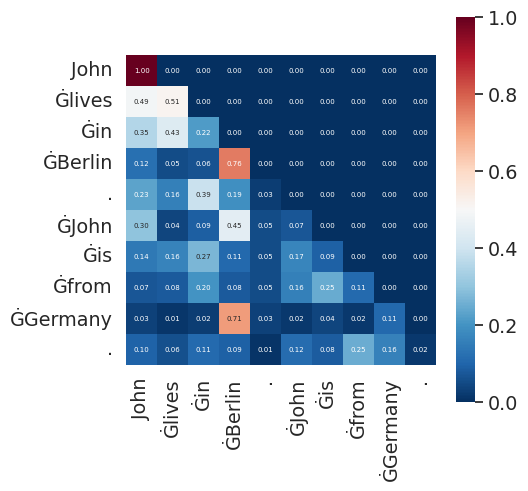

<Figure size 640x480 with 0 Axes>

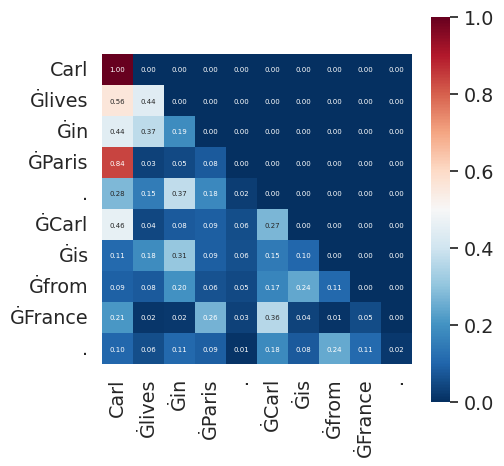

<Figure size 640x480 with 0 Axes>

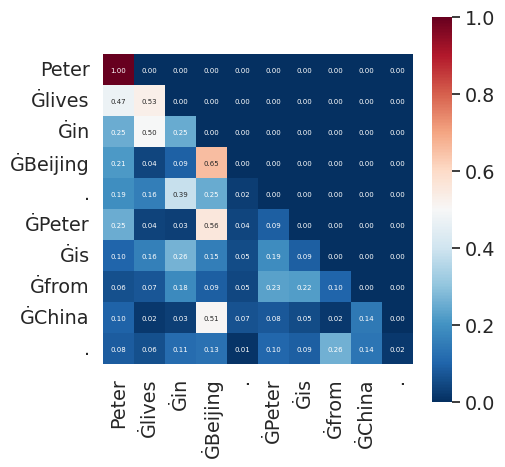

<Figure size 640x480 with 0 Axes>

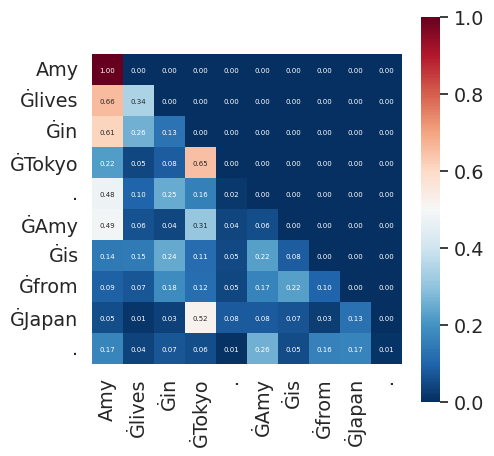

<Figure size 640x480 with 0 Axes>

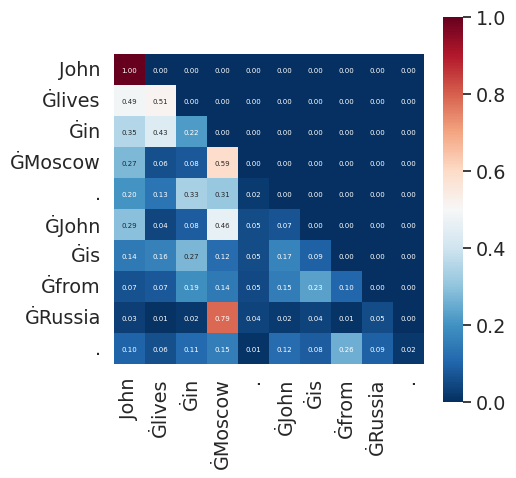

<Figure size 640x480 with 0 Axes>

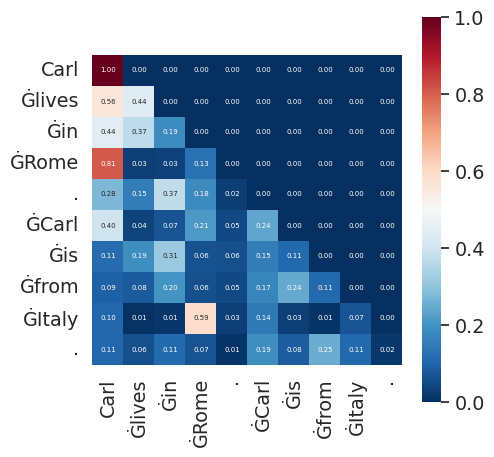

<Figure size 640x480 with 0 Axes>

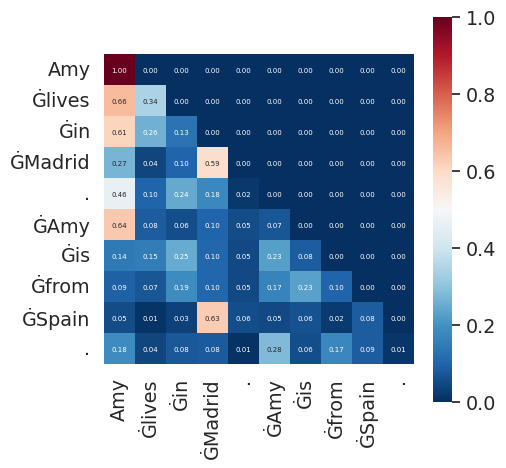

In [517]:
A = [0 for i in range(28*16)] #加和矩阵

sentences = ["John lives in Berlin. John is from Germany.",
"Carl lives in Paris. Carl is from France.",
"Peter lives in Beijing. Peter is from China.",
"Amy lives in Tokyo. Amy is from Japan.",
"John lives in Moscow. John is from Russia.",
"Carl lives in Rome. Carl is from Italy.",
"Amy lives in Madrid. Amy is from Spain."]


num = int(input("输入模式0-4："))
for s in sentences:
    sentence = s
    sent = tokenizer.tokenize(sentence)
    tokens = [tokenizer.decode([i]) for i in tokenizer.encode(sentence)]
    
    a = [] #attention权重矩阵 (flattern)
    typesd = [] #loc,name
    sd = [] #sou,des
    _dict = country_capital  #这里更改字典名
    
    inputs = tokenizer.encode_plus(sentence, return_tensors='pt')
    inputs = prepare_inputs(inputs, model.device)
    outputs = model(**inputs, output_attentions=True) #得到全部的attention矩阵
    #画某个head的注意力图
    drawpic(outputs,0,8)
    
    #匹配关注位置
    sou,des,n1,n2 = match(sentence,sent,_dict)
        
    for i in range(28):
        for j in range(16):
            a.append(outputs.attentions[i][0][j][sou][des].data.numpy())#倒数第一个参数是被关注位置，倒数第二为关注位置 sou(7)->des(2)
    A = [A[i]+ a[i] for i in range(len(a))]
#     A = [A[i]+ np.log(a[i]+(1e-9)) for i in range(len(a))]

[(6, 2, -0.051215192484378926),
 (0, 8, -0.08654008909668147),
 (5, 12, -0.10837026715538063),
 (1, 7, -0.11311787446366903),
 (3, 7, -0.1269347034245272),
 (0, 2, -0.1532011989350644),
 (1, 1, -0.17851177507775298),
 (8, 14, -0.18022957535893372),
 (7, 2, -0.1865316370300066),
 (8, 7, -0.19553579801463297)]

Text(0.5, 1.0, 'ĠSpain->ĠMadrid')

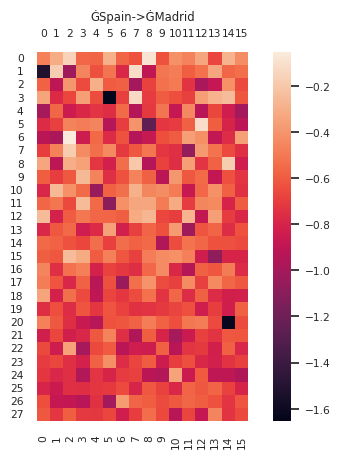

In [514]:
A = [A[i]/len(sentences) for i in range(len(A))]
b = np.array(A).reshape(28,16)
B = torch.from_numpy(b)
topk_md(B, 10, transpose=True)
x_texts = [i for i in range(0,16)]
y_texts = [i for i in range(0,28)]
plt.clf()
sns.set(font_scale=0.7)
hm = sns.heatmap(b,
                 cbar=True,
#                  cmap="RdBu_r",
                 annot=False,
                 square=True,
                 fmt='.2f',
                 
                 yticklabels = y_texts,
                 xticklabels = x_texts
                 )
ax = plt.gca()
ax.tick_params(labelbottom=True,labeltop=True)
title = "{}->{}".format(tokenizer.convert_ids_to_tokens(int(inputs.input_ids[0][sou])),tokenizer.convert_ids_to_tokens(int(inputs.input_ids[0][des])))
# title = "B{}->A{}".format("+"+str(n1) if n1>0 else "" , "+"+str(n2) if n2>0 else "")
plt.title(title)
plt.show()

[(1, 9, 0.7659438593047005),
 (1, 15, 0.672212438923972),
 (1, 14, 0.6255087426730565),
 (1, 12, 0.5911001563072205),
 (1, 2, 0.5897026019436973),
 (1, 10, 0.576962275164468),
 (2, 1, 0.5499320157936641),
 (3, 12, 0.5079178128923688),
 (2, 8, 0.4781034631388528),
 (1, 1, 0.4730495001588549)]

Text(0.5, 1.0, 'B->A+1')

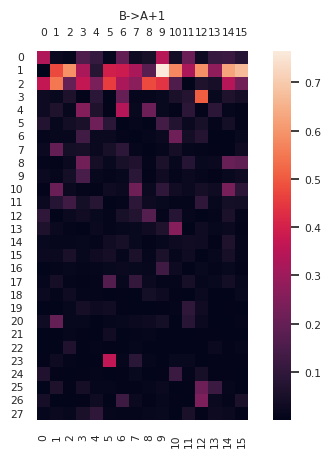

In [509]:
A = [A[i]/len(sentences) for i in range(len(A))]
b = np.array(A).reshape(28,16)
B = torch.from_numpy(b)
topk_md(B, 10, transpose=True)
x_texts = [i for i in range(0,16)]
y_texts = [i for i in range(0,28)]
plt.clf()
sns.set(font_scale=0.7)
hm = sns.heatmap(b,
                 cbar=True,
#                  cmap="RdBu_r",
                 annot=False,
                 square=True,
                 fmt='.2f',
                 
                 yticklabels = y_texts,
                 xticklabels = x_texts
                 )
ax = plt.gca()
ax.tick_params(labelbottom=True,labeltop=True)
# title = "{}->{}".format(tokenizer.convert_ids_to_tokens(int(inputs.input_ids[0][sou])),tokenizer.convert_ids_to_tokens(int(inputs.input_ids[0][des])))
title = "B{}->A{}".format("+"+str(n1) if n1>0 else "" , "+"+str(n2) if n2>0 else "")
plt.title(title)
plt.show()

In [181]:
outputs.attentions[0].size()

path = /nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/site-packages/pattern/text/en/en-verbs.txt


[autoreload of child_utils failed: Traceback (most recent call last):
  File "/nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/site-packages/pattern/text/__init__.py", line 609, in _read
    raise StopIteration
StopIteration

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exe

torch.Size([1, 16, 11, 11])

In [116]:
#并排展示多张图片
import ipywidgets as widgets
import IPython.display as display
## Read images from file (because this is binary, maybe you can find how to use ByteIO) but this is more easy
pic = []
for i in range(1):
    for j in range(1):
        img = open('nrk/attention/layer_{}_head_{}.png'.format(i+1,j+1), 'rb').read()
        ## Create image widgets. You can use layout of ipywidgets only with widgets.
        ## Set image variable, image format and dimension.
        IMG = widgets.Image(value=img, format='png', width=800, height=800)
        pic.append(IMG)
## Side by side thanks to HBox widgets
sidebyside = widgets.HBox(pic)
## Finally, show.
display.display(sidebyside)

In [147]:
outputs.attentions[0][0][0][-2][3]

tensor(0.0351, grad_fn=<SelectBackward0>)

/nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


test13第2层第6个head  B->A


<Figure size 640x480 with 0 Axes>

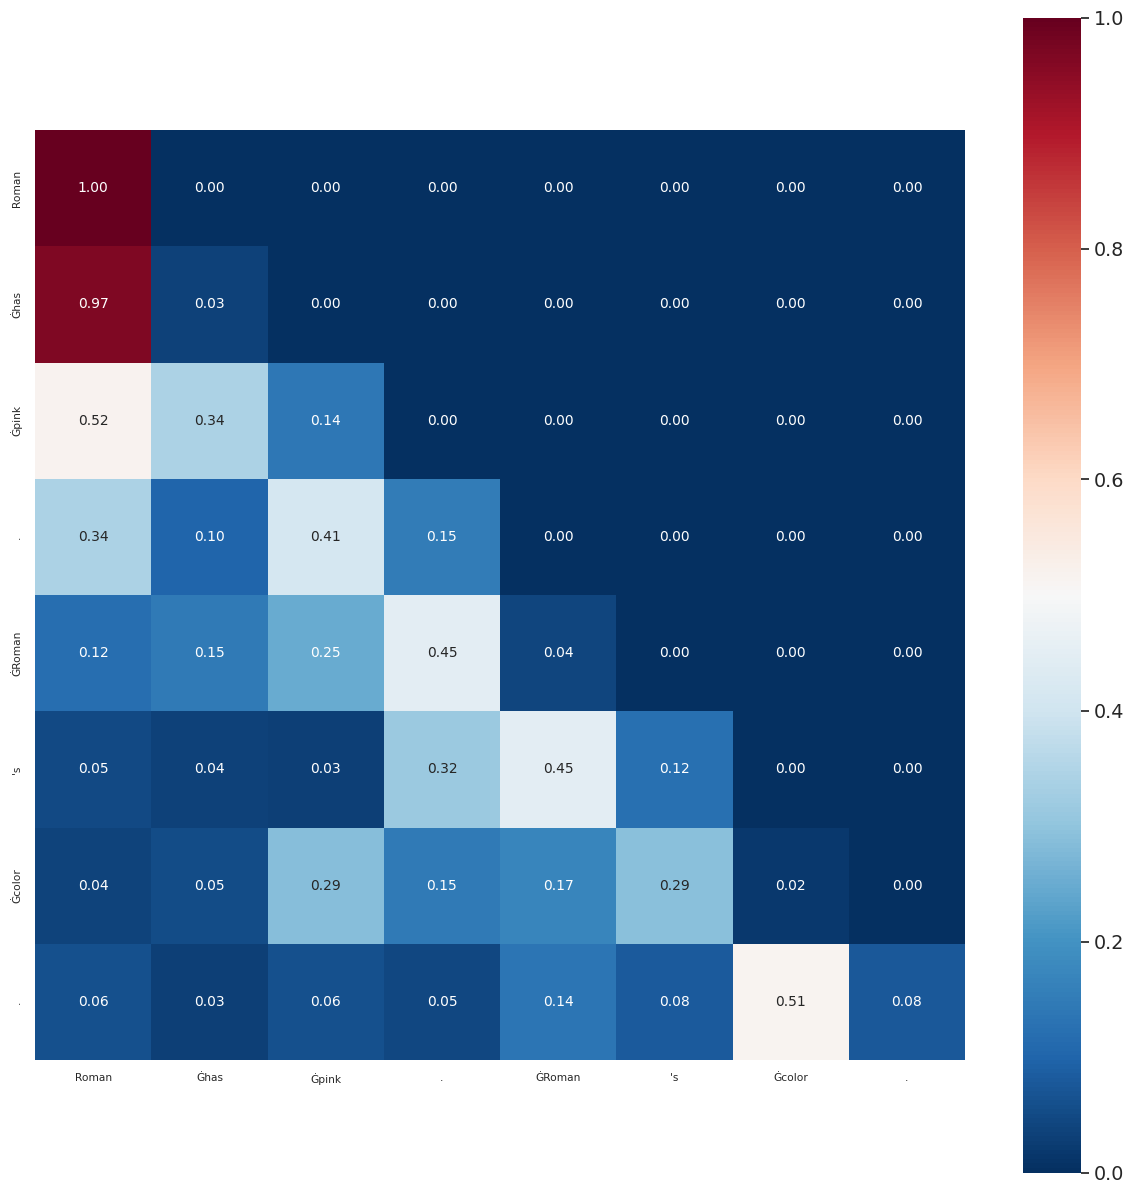

In [116]:
#绘制全部的注意力图


for k, v in outputs.items():
    if k == 'attentions':
        # Token ids
        ids = np.array(inputs['input_ids'][0], dtype=np.int)
        texts = tokenizer.convert_ids_to_tokens(ids)
        
test = 13 #实验编号
i,ii = (2,6)  # 层 ， head
attentions = outputs.attentions[i].detach().numpy()
print("test%d第%d层第%d个head  %s"%(test,i,ii,title))
attention_plot(attentions[0][ii], annot=True,x_texts = texts,y_texts = texts, figsize=(15, 15), figure_path='nrk/attention',
               figure_name='test_{}_layer_{}_head_{}_{}.png'.format(test,i,ii,title))


In [15]:
blocks[0].attn

GPTJBlock(
  (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
  (attn): GPTJAttention(
    (attn_dropout): Dropout(p=0.0, inplace=False)
    (resid_dropout): Dropout(p=0.0, inplace=False)
    (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
    (out_proj): Linear(in_features=4096, out_features=4096, bias=False)
  )
  (mlp): GPTJMLP(
    (fc_in): Linear(in_features=4096, out_features=16384, bias=True)
    (fc_out): Linear(in_features=16384, out_features=4096, bias=True)
    (act): NewGELUActivation()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (ln_2): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
)

In [92]:
blocks[0].ln_1(_e)

tensor([[-0.1049,  0.5451, -0.1121,  ...,  0.0290, -0.0708,  0.0978],
        [-0.1985, -0.0312, -0.3327,  ..., -0.2230,  0.4831, -0.7662],
        [ 0.0049, -0.2319, -0.0883,  ..., -0.2678,  0.0565,  0.0316],
        ...,
        [ 0.0481,  0.0198,  0.0410,  ...,  0.0201,  0.0788, -0.0143],
        [ 0.0808, -0.0009,  0.0976,  ...,  0.0079,  0.0592, -0.0069],
        [ 0.0940,  0.0225,  0.0583,  ...,  0.0438,  0.0633, -0.0087]],
       grad_fn=<NativeLayerNormBackward>)

In [27]:
attn

GPTJAttention(
  (attn_dropout): Dropout(p=0.0, inplace=False)
  (resid_dropout): Dropout(p=0.0, inplace=False)
  (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
  (out_proj): Linear(in_features=4096, out_features=4096, bias=False)
)

In [32]:
ln_f

LayerNorm((4096,), eps=1e-05, elementwise_affine=True)

In [33]:
L
H

28

16

In [520]:
we = _we
wu = _wu

NameError: name '_we' is not defined

In [ ]:
print("we:",we.size())
print("wv:",wv.size())
print("wq:",wq.size())
print("wk:",wk.size())
print("wu:",wu.size())
print("wo:",wo.size())

In [13]:
from weight_analysis import get_head_weights, plot_eigv, sample_all_top_entries, lookup_top_entries

In [14]:
torch.set_grad_enabled(False);

In [162]:
# def get_head_weights1(model, layer, head=None, transpose=True, absorb_ln=False):
#     m = model.transformer.h[layer].attn
#     H = m.num_heads
#     (qkv_pattern, o_pattern) = ('(n d) e -> n d e', 'e (n d) -> n e d') \
#         if not transpose else ('(n d) e -> n e d', 'e (n d) -> n d e')

#     wq, wk, wv = [rearrange(getattr(m, name).weight.data, qkv_pattern, n=H)
#                 for name in ['q_proj', 'k_proj', 'v_proj']]

#     if absorb_ln:
#         gamma = model.transformer.h[layer].ln_1.weight.data
#         pattern = qkv_pattern.split('->')[1].replace(' ', '')
#         pattern = pattern + ',e->' + pattern  # nde,e->nde or ned,e->ned
#         wq, wk, wv = [torch.einsum(pattern, w, gamma) for w in [wq, wk, wv]]
#     wo = rearrange(getattr(m, 'out_proj').weight.data, o_pattern, n=H)
#     if head is not None: wq, wk, wv, wo = [w[head] for w in [wq, wk, wv, wo]]
#     return wq, wk, wv, wo

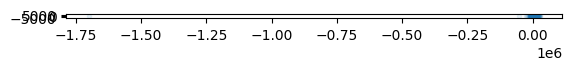

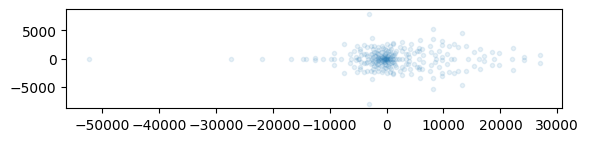

(-0.3945971131324768, 0.9673698544502258)

In [273]:
layer, head = 5,12# prev ov: 13-9, next num ov: 14-13, next word ov: 13-4, prepend space ov: 18-3/17-10, isa ov: 14-7, antonym ov: 16-14, copy ov 13-2
wq, wk, wv, wo = get_head_weights(model, layer, head, transpose=True)

e = blocks[layer].ln_1(_e[1])

qk = True
if qk:
    A, B = e @ wq, e @ wk
    m = A @ B.T
else:
    A, B = wu @ wo.T, e @ wv  #  wu, ln_f(e @ wv @ wo)  # slow for eig
    m = wu @ ln_f(B @ wo).T  # a little better than A @ B.T
plot_eigv((B.T @ A).eig()[0])

In [274]:
mean, std = m.mean(), m.std()

In [276]:
b = m > mean + std * 5

b.sum()
b.max(1).values.sum(), b.max(0).values.sum()

tensor(5111)

(tensor(2337), tensor(1108))

In [278]:
sample_all_top_entries(tokenizer, m, b, transpose = True)

  -- Ġ999 -- [('Ġ980', 3), ('Ġ385', 3)]
  -- .-- -- [('Texture', 3)]
  -- Sexual -- [('ĠSins', 3)]
  -- Ġgravitational -- [('Ġç¥ŀ', 7)]
  -- lahoma -- [('ĠYuk', 3)]
  -- ĠSaskatchewan -- [('ĠSask', 8), ('ĠCanad', 6), ('ĠAust', 5), ('ĠBrit', 3)]
  -- ĠWelsh -- [('ĠSask', 5)]
  -- aggressive -- [('ĠJama', 3)]
  -- Ġcollapsed -- [('Ġscram', 3)]
  -- NZ -- [('ĠAustralian', 10), ('Australian', 9), ('ĠCanadian', 8), ('Canadian', 7), ('ĠAustralia', 5), ('ĠAustralians', 4), ('ĠZealand', 3), ('Australia', 3)]
  -- Ġburying -- [('ĠCoffin', 5), ('ĠJudah', 4), ('Ġ365', 3)]
  -- Ġinsomnia -- [('ĠTem', 5)]
  -- Ġdrinking -- [('Ġbeverage', 3), ('ixir', 3)]
  -- producing -- [('Ġfert', 4)]
  -- Ġshowers -- [('Ġinaug', 5)]
  -- Ġlockdown -- [('ĠAust', 4)]
  -- Ġanthem -- [('ĠJama', 9)]
  -- 956 -- [('Ġ900', 5), ('Ġ950', 5), ('Ġ960', 4), ('Ġ1800', 3), ('Ġ1600', 3), ('Ġ1100', 3), ('Ġ570', 3), ('Ġ457', 3)]
  -- Ġammunition -- [('Ġcannon', 7), ('Ġgun', 6), ('Ġcue', 6), ('ĠGun', 4), ('Ġtorch', 4), ('ĠTri', 

In [297]:
# for country, (capital,) in country2capital().items():
print(lookup_top_entries(tokenizer, m.T, 'hand'))

{'Ġhandic': -11, 'Ġbilateral': -11, 'ilaterally': -12, 'Ġglove': -14, 'Ġfists': -15, 'Ġunilateral': -15, 'Ġtouchscreen': -16, 'ĠMelee': -16, 'Ġforearm': -16, 'Ġpaw': -16, 'Ġmerc': -16, 'ĠPLA': -16, 'Ġ______': -16, '76561': -16, 'ĠFinder': -16, 'Ġpalms': -16, 'ĠCasino': -17, '¥µ': -17, 'ĠChromebook': -17, 'Ġgraft': -17}


In [233]:
print(1)

1


In [173]:
qk = True
with torch.no_grad():  # ve,ed,de,ev->vv
    # _m = ln(mlp(_we.T)) @ (wq.T @ wk) @ T(ln)(T(mlp)(_we)) if qk else _wu @ T(ln_f)(wo @ (wv @ T(ln)(T(mlp)(_we))))
    _m = q @ k.T if qk else _wu @ ln_f(B @ wo).T

In [168]:
import numpy as np
a = "I love you"
input_ids = tokenizer(a, return_tensors= "pt" ).input_ids
print(input_ids)

tensor([[  40, 1842,  345]])


In [169]:
input_e = we[:,40]
for a in input_ids.numpy()[0]:
    if(a==40):
        pass
    else:
        input_e = torch.cat([input_e,we[:,a]],0)
result = input_e.view(3, -1)
#result是embedding后的值

In [170]:
result #3*4096

tensor([[-0.0030, -0.0226, -0.0012,  ...,  0.0095, -0.0021,  0.0038],
        [ 0.0116, -0.0291,  0.0179,  ...,  0.0078, -0.0187, -0.0089],
        [ 0.0118, -0.0147, -0.0039,  ...,  0.0141,  0.0086, -0.0063]])

In [171]:
q = result @ wq
q.size()
k = result @ wk
k.size()

torch.Size([3, 256])

torch.Size([3, 256])

In [698]:
import torch
import math
import torch.nn as nn

input= q @ k.T
A = nn.Softmax(dim=-1)(input)
# print(A)
h = A @ result @ (wv @ wo)
h = (A @ (result @ wv)) @ wo
print(h[0])


tensor([ 0.0017, -0.0014, -0.0017,  ...,  0.0013,  0.0016, -0.0028])


In [665]:
v = result @ wv

In [480]:
Vx = []
V = []
for a in input_ids.numpy()[0]:
    v = we[:,a]
    Vx.append(v)
for i in Vx:
    i = i.view(1,-1)
    v = i @ wv
    V.append(v)

In [526]:
Q = []
for i in Vx:
    q = i.view(1,-1) @ wq
    Q.append(q)
K = []
for i in Vx:
    k = i.view(1,-1) @ wk
    K.append(k)

In [674]:
torch.allclose(torch.cat(K)[2], k[2])

IndexError: index 3 is out of bounds for dimension 0 with size 3

In [680]:
(K[1][0] - k[1]).abs().max()

tensor(1.1921e-07)

In [681]:
k[1].abs().mean()

tensor(0.0463)

In [544]:
print((Q[0].view(1,-1)).T.size())
print((K[1].view(1,-1)).size())

torch.Size([256, 1])
torch.Size([1, 256])


In [610]:
#token1 
array = np.zeros((1,256))
A_s = torch.tensor(array)
WO = wo.type(torch.float64)
for i in [0,1,2]:
    A = Q[0].view(1,-1) @ K[i].view(1,-1).T
    print(A)
    A1 =  A @ V[i]#.view(1,-1)
    A_s += A1
h1 = A_s @ WO

#token2
A_s = torch.tensor(array)
for i in [0,1,2]:
    A = Q[1].view(1,-1) @ K[i].view(1,-1).T
    A1 =  A @ V[i]#.view(1,-1)
    A_s += A1
h2 = A_s @ WO

#token3
A_s = torch.tensor(array)
for i in [0,1,2]:
    A = Q[2].view(1,-1) @ K[i].view(1,-1).T
    A1 =  A @ V[i]#.view(1,-1)
    A_s += A1
h3 = A_s @ WO

H = h1
for a in [h2,h3]:
    H = torch.cat([H,a],0)
H = H.view(3, -1)


tensor([[0.4235]])
tensor([[0.4299]])
tensor([[0.4207]])


In [609]:
print(h)
print(H)


tensor([[ 0.0017, -0.0014, -0.0017,  ...,  0.0012,  0.0016, -0.0028],
        [ 0.0017, -0.0014, -0.0017,  ...,  0.0013,  0.0016, -0.0028],
        [ 0.0017, -0.0014, -0.0017,  ...,  0.0013,  0.0016, -0.0028]])
tensor([[ 0.0022, -0.0018, -0.0022,  ...,  0.0017,  0.0020, -0.0036],
        [ 0.0021, -0.0018, -0.0022,  ...,  0.0017,  0.0021, -0.0035],
        [ 0.0024, -0.0021, -0.0025,  ...,  0.0020,  0.0024, -0.0040]],
       dtype=torch.float64)


In [695]:
a2 = torch.cat(a2)

In [696]:
a2

tensor([[0.3329, 0.3351, 0.3320],
        [0.3399, 0.3323, 0.3277],
        [0.3441, 0.3306, 0.3252]])

In [699]:
A

tensor([[0.3329, 0.3351, 0.3320],
        [0.3399, 0.3323, 0.3277],
        [0.3441, 0.3306, 0.3252]])

In [703]:
a2 = []
#token1 
array = np.zeros((1,256))
A_s = torch.tensor(array)
WO = wo.type(torch.float64)
AIJ = Q[0].view(1,-1) @ K[0].view(1,-1).T
for i in [1,2]:
    A = Q[0].view(1,-1) @ K[i].view(1,-1).T
    AIJ = torch.cat([AIJ,A],0)
aij = nn.Softmax(dim=-1)(AIJ.view(1,-1))  
a2.append(aij)
for i,A in enumerate(aij[0]):  
    A1 =  A.view(1,-1) @ V[i]#.view(1,-1)
    A_s += A1
h1 = A_s @ WO


#token2
A_s = torch.tensor(array)
AIJ = Q[1].view(1,-1) @ K[0].view(1,-1).T
for i in [1,2]:
    A = Q[1].view(1,-1) @ K[i].view(1,-1).T
    AIJ = torch.cat([AIJ,A],0)
aij = nn.Softmax(dim=-1)(AIJ.view(1,-1))  
a2.append(aij)
for i,A in enumerate(aij[0]):  
    A1 =  A.view(1,-1) @ V[i]#.view(1,-1)
    A_s += A1
h2 = A_s @ WO


#token3
A_s = torch.tensor(array)
AIJ = Q[2].view(1,-1) @ K[0].view(1,-1).T
for i in [1,2]:
    A = Q[2].view(1,-1) @ K[i].view(1,-1).T
    AIJ = torch.cat([AIJ,A],0)
aij = nn.Softmax(dim=-1)(AIJ.view(1,-1))  
a2.append(aij)
for i,A in enumerate(aij[0]):  
    A1 =  A.view(1,-1) @ V[i]#.view(1,-1)
    A_s += A1
h3 = A_s @ WO


H = h1
for a in [h2,h3]:
    H = torch.cat([H,a],0)
H = H.view(3, -1)


In [702]:
torch.allclose(h[0], h[2])

False

In [704]:
print(h)
print(H)

tensor([[ 0.0017, -0.0014, -0.0017,  ...,  0.0013,  0.0016, -0.0028],
        [ 0.0017, -0.0014, -0.0017,  ...,  0.0014,  0.0016, -0.0028],
        [ 0.0017, -0.0014, -0.0017,  ...,  0.0014,  0.0016, -0.0028]])
tensor([[ 0.0017, -0.0014, -0.0017,  ...,  0.0013,  0.0016, -0.0028],
        [ 0.0017, -0.0014, -0.0017,  ...,  0.0014,  0.0016, -0.0028],
        [ 0.0017, -0.0014, -0.0017,  ...,  0.0014,  0.0016, -0.0028]],
       dtype=torch.float64)


In [706]:
torch.allclose(h, H.float())

True

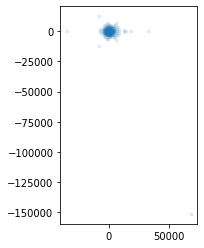

0.17757728695869446

In [98]:
plot_eigv((k.T @ q).eig()[0] if qk else (B.T @ A).eig()[0], start_i=1)

In [99]:
m = _m  # q->k, output->input
# m = _m.T  # k->q, input->output
values, indices = m.topk(10)

In [ ]:
( -> )
[ -> ]
{ -> }
(( -> ))
< -> >

In [174]:
show_topk.indices_fn = tokenizer.convert_ids_to_tokens
ans1 = []
for i in values.mean(1).topk(1000).indices.tolist():
    ans = tokenizer.convert_ids_to_tokens(i), show_topk(values[i][:6].long(), indices[i][:6])
#     ans1.append([ans,i])

    print(tokenizer.convert_ids_to_tokens(i), show_topk(values[i][:6].long(), indices[i][:6]))

NameError: name 'values' is not defined

In [64]:
i = tokenizer.encode(' I love yuo')[0];
print(i)
print(tokenizer.convert_ids_to_tokens(i))
# show_topk(*m[i].topk(20))

314
ĠI


In [105]:
i = tokenizer.encode(' !)')[0]; 
print(tokenizer.convert_ids_to_tokens(i))
show_topk(*m[i].topk(20))

Ġ!


{'ĠMerry': 29.408,
 'ĠEminem': 28.619,
 'ĠLimbaugh': 28.026,
 'ĠKendall': 27.807,
 'ĠHogan': 27.728,
 'ĠMelania': 27.219,
 'ĠZap': 27.216,
 'ĠHuawei': 27.003,
 'ĠShiva': 26.809,
 'ĠBarbie': 26.793,
 'ĠSergei': 26.767,
 'ĠMiliband': 26.68,
 'ĠSchwar': 26.567,
 'ĠDempsey': 26.444,
 'ĠMalik': 26.387,
 'ĠRouse': 26.308,
 'ĠSutherland': 26.208,
 'ĠSasuke': 26.203,
 'ĠHowell': 26.035,
 'ĠMilo': 25.878}

In [27]:
prompt_token = 'Ġ!'; prompt_id = tokenizer._convert_token_to_id(prompt_token)
bop_str = 'Instruction: '; bop_id = tokenizer.encode(bop_str)[0]  # 'Inst'
eop_str = '. For example:'; eop_id = tokenizer.encode(eop_str)[2] # 'Ġexample'
bos_id = tokenizer._convert_token_to_id('Ġ->')
eos_id = tokenizer._convert_token_to_id('Ċ')


class CHILDDataset(Dataset):
    def __init__(self, input_strs, tokenizer):
        if tokenizer.pad_token is None: tokenizer.pad_token = '!'
        self.inputs = tokenizer.batch_encode_plus(input_strs, add_special_tokens=False, padding=True, return_tensors='pt')#长的截，短的补
        input_ids = self.inputs.input_ids
        self.labels = torch.ones_like(input_ids) * (-100)

        for bi in range(input_ids.size(0)): 
            bop_idx = (input_ids[bi] == bop_id).nonzero().squeeze(1) #prompt
            eop_idx = (input_ids[bi] == eop_id).nonzero().squeeze(1) #context

            if len(bop_idx) > 0:
                assert len(bop_idx) == 1 and len(eop_idx) == 1
                bop_idx, eop_idx = bop_idx.item(), eop_idx.item() #取出单元素张量的元素值并返回该值，保持原元素类型不变
                #bop: 0   eop:6
                input_ids[bi, bop_idx: eop_idx + 2] *= -1  # use prompt embedding for prompt tokens
  
            bos_indices = (input_ids[bi] == bos_id).nonzero().squeeze(1)
#             print("bos_indices:",bos_indices)
            eos_indices = (input_ids[bi] == eos_id).nonzero()[-len(bos_indices):].squeeze(1) #每一位 eos都比bos大2
#             print("eos_indices:",eos_indices)
            for i, (bos_i, eos_i) in enumerate(zip(bos_indices.tolist(), eos_indices.tolist())):
                assert eos_i > bos_i + 1
                if i >= 0:  #zero-shot
                    self.labels[bi, bos_i + 1: eos_i] = input_ids[bi, bos_i + 1: eos_i] 
        
        
    def re_input(self):
        return self.inputs['input_ids']
        
    def __len__(self):
        return len(self.inputs['input_ids'])

    def __getitem__(self, i):
        return {'input_ids': self.inputs['input_ids'][i],  #输入
                'attention_mask': self.inputs['attention_mask'][i],
                'labels': self.labels[i]}   #结果

In [28]:
bos_id,eos_id

(4613, 198)

In [29]:
from child_utils import *
torch.set_printoptions(threshold=np.inf)

In [113]:
class WrappedEmbedding(nn.Module):
    def __init__(self,  
                wte: nn.Embedding,  #正常向量
                prompt_id: int = None,
                prompt_len: int = 10, 
                random_range: float = 0.5,
                initialize_from_vocab: bool = True):
        super(WrappedEmbedding, self).__init__()
#         self.wte = wte
#         self.prompt_id = prompt_id
#         self.prompt_len = prompt_len
        self.__dict__.update(locals()); del self.self #locals()以字典类型返回当前位置的全部局部变量
        if self.prompt_id is not None: #prompt_embedding prompt词向量
            self.prompt_embedding = nn.parameter.Parameter( #将一个不可训练的类型Tensor转换成可以训练的类型parameter
                self.initialize_embedding(random_range, initialize_from_vocab)).to(self.wte.weight.device) #在-0.5-0.5中随机取值初始化
        else:
            self.prompt_embedding = nn.Embedding(self.prompt_len, self.wte.weight.size(1)).to(self.wte.weight.device)
                                        #词典大小（总共输入多少词） 嵌入向量维度（多少维表示一个符号）
            assert initialize_from_vocab
            self.init_prompt_embedding_()  #将wte的weight值作为初始化
#             self.prompt_embedding.weight.data = self.initialize_embedding(random_range, initialize_from_vocab)     
 
    def initialize_embedding(self, random_range: float = 0.5, initialize_from_vocab: bool = True):
        if initialize_from_vocab: return self.wte.weight[:self.prompt_len].clone().detach() #返回一个新的tensor，新的tensor和原来的tensor共享数据内存，但不涉及梯度计算
        return torch.FloatTensor(self.prompt_len, self.wte.weight.size(1)).uniform_(-random_range, random_range) #产生随机数
    
    def init_prompt_embedding_(self):
#         print(self.wte.weight)
        self.prompt_embedding.weight.data[:] = self.wte.weight[:self.prompt_len]

        
    def forward(self, input_ids):
        if self.prompt_id is not None:
            input_embeds = self.wte(input_ids)
            input_embeds[input_ids == self.prompt_id] = self.prompt_embedding.expand(input_embeds.size(0), -1, -1)
        else: # adapted from cpm-2
            prompt_mask = input_ids < 0  #返回bool类型
#             print("prompt_mask:",prompt_mask.shape)
            prompt_ids = -input_ids * prompt_mask #将prompt的值变为正数，其他置零
#             print("prompt_ids:",prompt_ids)
#             print(prompt_ids < self.prompt_len)
#             print(prompt_ids)
            assert torch.all(prompt_ids < self.prompt_len)
#             print(self.prompt_embedding(prompt_ids).shape)
            p_embeds = self.prompt_embedding(prompt_ids) * prompt_mask.float().unsqueeze(-1)
#             print("p_embeds:",p_embeds.shape)
            input_ids = input_ids * ~prompt_mask
            w_embeds = self.wte(input_ids) * (~prompt_mask).float().unsqueeze(-1)
#             print("w_embeds:",w_embeds.shape)
            input_embeds = w_embeds + p_embeds 
#         print(input_embeds)
        return input_embeds

IndentationError: unexpected indent (<ipython-input-113-af135889c570>, line 20)

In [31]:
# adapted from cpm-2: https://github.com/TsinghuaAI/CPM-2-Finetune/blob/master/utils.py#L133-L164    #不训练模型参数，只训练prompt_embading，这个函数是取这些参数
def get_params_for_prompt_optimization(module: nn.Module): 
    params = []
    for t in module.named_modules():
        if "prompt_embedding" in t[0]:
            params.append({'params': [p for p in list(t[1]._parameters.values()) if p is not None]})
    for t in module.named_parameters():
        if "prompt" not in t[0]:
            t[1].requires_grad_(False)    
    return params

def create_optimizer(model, training_args):
    from torch.nn.parallel.distributed import DistributedDataParallel as DDP
    while isinstance(model, (DDP, )): model = model.module
        
    we.init_prompt_embedding_()
    param_groups = get_params_for_prompt_optimization(model)
    optimizer = AdamW(param_groups, lr=training_args.learning_rate, 
                      betas=(training_args.adam_beta1, training_args.adam_beta2),eps=training_args.adam_epsilon)
    return optimizer

In [118]:
wte = model.get_input_embeddings() #提取 embedding 中的 词向量部分
print(wte.weight.size(1))
# if hasattr(wte, 'wte'): wte = wte.wte  # already been wrapped
# we = WrappedEmbedding(wte, prompt_len=20000)
# model.set_input_embeddings(we) #为词向量赋值

4096


In [33]:
def verbalize(obj):
    if type(obj) == bool: return 'Yes' if obj else 'No'
    return str(obj)

def list2str(l): return ' '.join(str(i) for i in l)
def pairs2str(pairs): return ', '.join(str(k) + ': ' + str(v) for k, v in pairs)

def make_context_str(cxt):
    if type(cxt) == list:
        return pairs2str(cxt) if type(cxt[0]) == tuple and len(cxt[0]) == 2 else list2str(cxt)
    if type(cxt) == tuple:
        return '; '.join(make_context_str(c) for c in cxt)  # 用分号分隔context的不同部分
    
def make_query_str(instruction, query):
    if instruction is None and query is None: return ''
    s = '.'
    if instruction is not None: s = s + ' ' + instruction
    if query is not None:
        if type(query) in [int, bool, str]: query = [query]
        if type(query) == dict:# and list(query.keys())[0] != "CS"):  # by nrk
            s = s + ' ' + '{' + ','.join([' replace %s with %s' % (str(k), str(v)) for k, v in query.items()]) + ' }'
        if type(query) in [list, tuple]:
            s = s + ' ' + ' '.join([list2str(i) if type(i) == list else str(i) for i in query])
    return s

def make_example_str(example, query2str):
    instruction, cxt, query, ans = example
    if type(ans) not in [Sequence, list]: ans = [ans]
    ans = [verbalize(a) for a in ans]
#     return '%s -> %s' % (''.join(l[0]) + make_query_str(instruction if with_instruction else None, query), ' '.join(ans))  # by nrk
#     return '%s -> %s' % (' '.join(l) + make_query_str(instruction if with_instruction else None, query), ' '.join(ans))  # by XD
#     return '%s -> %s' % (make_context_str(cxt) + make_query_str(instruction if with_instruction else None, query[0]), ' '.join(ans))
    return '%s -> %s' % (make_context_str(cxt) + query2str(query), ' '.join(ans))


def sample_rand_len(vocab, k): return sample(vocab, k=randint(1, k))

In [27]:
def promptize(s):
#     return prompt_token * len(s.split())
    return bop_str + s + eop_str

courses_vocab=["Sql","Math","English","Chinese","Art","Music","History","Biology","Chemistry","Physics","Geography"]
all_vocab = ["apple","pear","peach","grape","banana","pineapple","lemon","strawberry","cola","juice","coffee","milk","wine","beer","whisky","vodka","brandy"]
solid_vocab=["apple","pear","peach","grape","banana","pineapple","lemon","strawberry"]
liquid_vocab=["cola","juice","coffee","milk","wine","beer","whisky","vodka","brandy"]
names_vocab =  [i for i in string.ascii_uppercase]
depts_vocab = ["CS","Chi","Eng","Mat"]
sl = ["solid"]*len(solid_vocab)+["liquid"]*len(liquid_vocab)
sl_vocab = dict(zip(all_vocab,sl))
toys = ["ball","doll","puppet","weiqi","chess","slide","diabolo","plasticine","tumbler"]
                                              #滑梯     空竹      橡皮泥      不倒翁
boys = ["Alex","Dylan","Daniel","Patrick","Austin","Harrison","Tom","Neil"]
girls = ["Ashley","jessica","Sarah","Amanda","Nicole","Katherine","Anne","Eva"]
all = boys+girls
bg = ["boys"]*len(boys)+["girls"]*len(girls)
bg_vocab = dict(zip(all,bg))

all = solid_vocab+toys
ft = ["fruits"]*len(solid_vocab)+["toys"]*len(toys)
ft_vocab = dict(zip(all,ft))

def make_input_str(task, nrows=4, ncols=4, full_vocab=None, ans_vocab=[True, False]):
    if full_vocab is None: full_vocab = string.ascii_uppercase + string.digits
    transform_fn, vocab_fn, sample_fn, query_fn, query2str = task
    instruction = transform_fn.__name__.replace('_', ' ')
    if vocab_fn is None: vocab_fn = lambda: full_vocab
    if query_fn is None: query_fn = lambda *_: None
        
    examples = []
    query = None
    for i in range(nrows):
        vocab = vocab_fn()
        l = sample_fn(vocab, k=ncols)
        query = query_fn(l, vocab, ncols)
        examples.append([instruction, l, query, transform_fn(l, query=query)])
#     examples = balance(examples,ans_vocab)

    desc = promptize(instruction) if True else ''
    text = '\n'.join([make_example_str(e, query2str) for e in examples])
    text = desc + '\n' + text + '\n'
    return text

In [17]:
# # def balance(examples, ans_vocab=[True, False]):
# def balance1(examples, ans_vocab):
#     groups = seq(examples).group_by(_[-1]).map(_[1])  # 按ans分组
# #     assert groups.len() == len(ans_vocab), '%d < %d' % (groups.len(), len(ans_vocab))  # 保证每种ans都出现
#     min_cnt = groups.map(lambda x: len(x)).min()
#     examples = groups.map(lambda x: sample(x, min_cnt)).flatten().list() # 每组都采样最小个数后去分组
#     return sample(examples, len(examples))  # 重新打乱

In [18]:
def balance(examples, ans_vocab):
    groups = seq(examples).group_by(_[-1]).map(_[1])  # 按ans分组
#     min_cnt = groups.map(lambda x: len(x)).min()
    min_cnt =3
    if(groups.len()>3):
        min_cnt = 3
    elif(groups.len()==3):
        min_cnt = 3
    if(min_cnt > 2):
        examples = groups.map(lambda x: sample(x, 3)).flatten().list() # 每组都采样最小个数后去分组
        return sample(examples, len(examples))  # 重新打乱
    else:
        examples = groups.map(lambda x: sample(x, min_cnt)).flatten().list() # 每组都采样最小个数后去分组
        return sample(examples, len(examples))  # 重新打乱

In [19]:
import itertools  
def Do_all_students_choose_courses_in_a_department(cxt, query):
    SC, CD = cxt  # SC paris: studeng-course relation, CD pairs: course-department function
    ss, d = query  # ss: 学生子集（可以*不止两个学生*），d: 课程
#     return seq(ss).map(lambda s: seq(SC).filter(_[0] == s).map(_[1]).intersection(CD.filter(_.[1] == d).map(_.[0])).non_empty()).all()
    return (seq(ss)
            .map(lambda s: seq(SC).filter(_[0] == s).map(_[1])  # 学生s选的所有课程
                 .intersection(
                     seq(CD).filter(_[1] == d).map(_[0])) # d系的课程
                 .non_empty())  # s选了d系的课程
            .all())  # 学生子集ss都选了d系的课程

def all_a_sample(vocab, k):
    S_vocab, C_vocab, D_vocab = vocab  # vocabs of students, courses, departments
    k_S, k_C, k_D, k_SC = k  # default values: k_S = 3, k_C = 3, k_D = 2, k_SC = 5
    S, C, D = sample(S_vocab, k_S), sample(C_vocab, k_C), sample(D_vocab, k_D)
    
    while len(set(CD := choices(D, k=k_C))) < k_D: continue  # ds里每个系的课都要出现
    CD = list(zip(C, CD))  # 得到每门课所属的系
    
    all_SC = list(itertools.product(S, C))  # or seq(S).cartesian(C).list()
    while seq(SC := sample(all_SC, k_SC)).map(_[0]).distinct().len() < k_S: continue  # ss里每个学生都要选课
    return SC, CD

def select_distinct(tuples, col): return seq(tuples).map(_[col]).distinct().list()
    
def all_a_query(cxt,vocab,k):
    SC, CD = cxt
    k_S, k_C, k_D, k_SC = k
    S, D = select_distinct(SC, 0), select_distinct(CD, 1)
#     k_ss = randint(2, len(S))
    ss = sample(S, 2)
    d = choice(D)
    return ss, d

def all_a_query2str(query):
    ss, d = query
    query_str = '%s,%s?' % (', '.join(ss[:-1]) + ' and ' + ss[-1], d)
    return '. ' + query_str


In [20]:
def all_b(cxt, query):
    SC, CD = cxt
    ss,d = query
    return (seq(CD).filter(_[1] == d).map(_[0])
                 .difference(
                     seq(SC).filter(_[0] == ss).map(_[1]))
                 .empty())

def all_b_sample(vocab, k):
    S_vocab, C_vocab, D_vocab = vocab  
    k_S, k_C, k_D, k_SC = k  # default values: k_S = 2, k_C = 3, k_D = 2, k_SC = 5
    S, C, D = sample(S_vocab, k_S), sample(C_vocab, k_C), sample(D_vocab, k_D)
    
    while len(set(CD := choices(D, k=k_C))) < k_D: continue  
    CD = list(zip(C, CD)) 
    
    all_SC = list(itertools.product(S, C))  
    while seq(SC := sample(all_SC, k_SC)).map(_[0]).distinct().len() < k_S: continue  # ss里每个学生都要选课
    return SC, CD
   
def all_b_query(cxt,vocab,k):  # XD: 不要给qeury_fn加st参数
    SC, CD = cxt
    k_S, k_C, k_D, k_SC = k
    S, D = select_distinct(SC, 0), select_distinct(CD, 1)
#     k_ss = randint(2, len(S))  # XD: k_ss unused
    ss = choice(S)
    d = choice(D)
    return ss, d
    # XD: 不要在query_fn里转str！！这里转str，transform_fn里再解析回来，两边不是白折腾吗！

def all_b_query2str(query):
    ss, d = query
    query_str = 'Does %s take all %s courses?' % (ss, d)
    return '. ' + query_str


def Is_the_intersection_of_two_sets_empty(cxt, query):
    SC= cxt
    s,d = query
    return (seq(SC).filter(_[0] == s).map(_[1])
                 .intersection(
                     seq(SC).filter(_[0] == d).map(_[1]))
                 .non_empty())

def intersection_query(cxt,vocab,k):
    SC= cxt
    k_S, k_C, k_SC = k #k_s = 3, k_C = 5 , k_sc = 6
    S = select_distinct(SC, 0)
    s,d = sample(S,2)
    return s, d

def intersection_query2str(query):
    s, d = query
    query_str = "%s,%s?" % (s, d)
    return '. ' + query_str

def intersection_sample(vocab, k):
    S_vocab, C_vocab = vocab  
    k_S, k_C, k_SC = k  # k_S = 3, k_C = 5, , k_SC = 6
    S, C= sample(S_vocab, k_S), sample(C_vocab, k_C)
    all_SC = list(itertools.product(S, C))  
    while seq(SC := sample(all_SC, k_SC)).map(_[0]).distinct().len() < k_S: continue 
    return SC

def Is_the_first_set_a_subset_of_the_second_one(cxt, query):
    SC= cxt
    s,d = query
    return (seq(SC).filter(_[0] == d).map(_[1])
                 .union(
                     seq(SC).filter(_[0] == s).map(_[1]))
                 ).distinct().len()== seq(SC).filter(_[0] == d).map(_[1]).distinct().len()

def complement_query(cxt,vocab,k):
    SC= cxt
    k_S, k_C, k_SC = k #k_s = 3, k_C = 5 , k_sc = 6
    S = select_distinct(SC, 0)
    s,d = sample(S,2)
    return s, d

def complement_query2str(query):
    s, d = query
    query_str = "%s,%s?" % (s, d)
    return '. ' + query_str

def complement_sample(vocab, k):
    S_vocab, C_vocab = vocab  
    k_S, k_C, k_SC = k  # k_S = 3, k_C = 4, k_SC = 5
    S, C= sample(S_vocab, k_S), sample(C_vocab, k_C)
    all_SC = list(itertools.product(S, C))  
    while seq(SC := sample(all_SC, k_SC)).map(_[0]).distinct().len() < k_S: continue 
    return SC

def Are_they_the_union_of_the_last_element(cxt, query):
    SC, DC = cxt
    ss,d = query
    return (seq(ss)
            .map(lambda s: seq(SC).filter(_[0] == s).map(_[1]) 
                 .union(
                     seq(DC).filter(_[0] == d).map(_[1])) 
                 .distinct().len() == seq(DC).filter(_[0] == d).map(_[1]).distinct().len())  
            .all()) 

def union_sample(vocab, k):
    S_vocab, C_vocab, D_vocab = vocab  
    k_S, k_C, k_D, k_SC = k  # k_S = 3, k_C = 4, k_D = 2, k_SC = 6
    S, C, D = sample(S_vocab, k_S), sample(C_vocab, k_C), sample(D_vocab, k_D)
    
    while len(set(DC := choices(D, k=k_C))) < k_D: continue  
    DC = list(zip(DC,C)) 
    
    all_SC = list(itertools.product(S, C))  
    while seq(SC := sample(all_SC, k_SC)).map(_[0]).distinct().len() < k_S: continue  
    return SC, DC
   
def union_query(cxt,vocab,k): 
    SC, DC = cxt
    k_S, k_C, k_D, k_SC = k
    S, D = select_distinct(SC, 0), select_distinct(DC, 0)
    k_ss = randint(2, len(S))
    ss = sample(S, k_ss)
    d = choice(D)
    return ss, d

def union_query2str(query):
    ss, d = query
    query_str = '%s,%s?' % (', '.join(ss[:-1]) + ' and ' + ss[-1], d)
    return '. ' + query_str

def Are_there_elements_belonging_to_the_same_class(cxt, query): #新建联系，把vocab和属性连起来形成新集合
    NA, DA = cxt
    s,d = query
    D = seq(DA).filter(_[0] == d).map(_[1])
    return (seq(NA).filter(_[0] == s).map(_[1]).select(lambda x: sl_vocab[x] == sl_vocab[D[0]]).any())
      
    
def find_sample(vocab, k): 
    name_vocab, all_vocab = vocab
    k_name, k_all, k_D, k_SA = k  # k_name = 3, k_all = 4, k_D = 2, k_SA = 6
    S = list(all_vocab.keys())
    N, A, D = sample(name_vocab, k_name), sample(S, k_all), sample(string.ascii_lowercase, k_D)
#     D = sample(d := name_vocab.pop(name_vocab.index(a) for a in N),k_D)
    A1 = sample(S, k_D)
    DA = list(zip(D,A1)) 
    
    all_NA = list(itertools.product(N, A))  
    while seq(NA := sample(all_NA, k_SA)).map(_[0]).distinct().len() < k_name: continue  
    return NA, DA
   
def find_query(cxt,vocab,k): 
    NA, DA = cxt
    k_name, k_all, k_D, k_SA = k
    S,D = select_distinct(NA, 0), select_distinct(DA, 0)
    s,d = choice(S), choice(D)
    return s, d

def find_query2str(query):
    s, d = query
    query_str = '%s,%s?' % (s, d)
    return '. ' + query_str


def Are_there_any_elements_different_from_other_elements(cxt, query):
    NA = cxt
    ss = query
    return (seq(ss).map(lambda s: seq(NA).filter(_[0] == s).map(_[1])
                        .select(lambda x: sl_vocab[x])[0])
            .distinct().len( ) == 2)
               
def find_dif_sample(vocab, k):
    name_vocab, all_vocab = vocab
    k_name, k_all, k_SA = k  # k_name = 4, k_all = 4, k_SA= 3
    N, A = sample(name_vocab, k_name), sample(list(all_vocab.keys()), k_all) 
    NA = list(zip(N,A)) 
    return NA
   
def find_dif_query(cxt,vocab,k): 
    NA = cxt
    k_name, k_all, k_NA = k
    S = select_distinct(NA, 0)
    ss = sample(S,k_NA)
    return ss


def find_dif_query2str(query):
    ss = query
    query_str = '%s?' % (', '.join(ss[:-1]) + ' and ' + ss[-1])
    return '. ' + query_str



In [21]:
def How_many_elements_are_similar_to_the_case(cxt, query):
    s = cxt
    q = query
    return seq(s).filter(lambda x: sl_vocab[x] == sl_vocab[q[0]]).len()
                     
def count_sample(vocab, k):
    all_vocab = vocab
    k_cxt,k_query = k  # k_cxt = 4 ,k_query =1
    N = list(all_vocab.keys())
    s = sample(N, k_cxt) 
    return s
   
def count_query(cxt,vocab,k): 
    NA = cxt
    k_cxt,k_query = k
    N = list(vocab.keys())
    q = sample(N,k_query)
    return q

def count_query2str(query):
    q = query
    query_str = '%s?' % (q[0])
    return '. ' + query_str

def Is_the_number_of_first_elements_greater_than_the_second_one(cxt, query):
    s = cxt
    q = query
    return (seq(s).filter(lambda x: sl_vocab[x] == sl_vocab[q[0]]).len() >= len(s)/2)
                     
def compare_sample(vocab, k):
    all_vocab,s_vocab,l_vocab = vocab
    k_cxt,k_query = k  # k_cxt = 5 ,k_query =2
    N = list(all_vocab.keys())
    s = sample(N, k_cxt) 
    return s
   
def compare_query(cxt,vocab,k): 
    NA = cxt
    all_vocab,s_vocab,l_vocab = vocab
    k_cxt,k_query = k
    q = sample(s_vocab,1)+sample(l_vocab,1)
    random.shuffle(q)
    return q

def compare_query2str(query):
    ss,q = query
    query_str = '%s,%s?' % (ss,q)
    return '. ' + query_str

In [22]:
def Ascii_size_existence(l, query): return seq(l).map(_[0] > query).any()
def Ascii_size_all(l, query): return seq(l).map(_[0] > query).all()
def Ascii_size_None(l, query): return seq(l).filter(_[0] > query).empty()
def ith_element(l, query=None): return seq(l).slice(1, 2)
def ith_group(l, query=None): return seq(l).group_by(_).select(_[1]).slice(1, 2).flatten()#.distinct()# davinci F w/ and wo dist
# def element_at_index(l, query): return seq(l).slice(query, query + 1) # davinci F
def element_at_index(l, query): return seq(l).enumerate().filter(_[0] == query).select(_[1])
def replace(l, query): return seq(l).map(lambda x: query.get(x, x))
def replace_with_the_other(l, query): # davinci F
    query = {k: (set(l) - {k}).pop() for k in l}
    return replace(l, query)
def replace_all_with(l, query): return seq(l).map(lambda x: query)  # davinci F?!
def interleave_with(l, query): return seq(l).flat_map(lambda x: [x, query])  # davinci T!!
def unique_elements(l, query=None): return seq(l).distinct() # davinci F
def how_many_unique_elements(l, query=None): return seq(l).distinct().len()  # davinci F
def how_many(l, query): return seq(l).filter(_ == query).len() # davinci F
def select_same_as(l, query): return seq(l).filter(_ == query) # simpler version of how_many. davinci F
def select_same_number_as(l, query): return seq(l).group_by(_).select(_[1]).filter(lambda x: len(x) == len(query)).flatten() # F
def includes(l, query): return seq(l).union(seq(query)).distinct().len() == seq(l).distinct().len() # davinci F
def is_included_by(l, query): return seq(l).difference(seq(query)).empty() # davinci F

In [23]:
def Compare_the_values_of_two_sets(cxt, query):
    s = cxt
    q = query
    if(seq(s).filter(lambda x: sl_vocab[x] == sl_vocab[q[0]]).len() > len(s)/2):
        return ">"
    elif(seq(s).filter(lambda x: sl_vocab[x] == sl_vocab[q[0]]).len() < len(s)/2):
        return "<"
    else:
        return "="

def Compare_sample(vocab, k):
    all_vocab,s_vocab,l_vocab = vocab
    k_cxt,k_query = k  # k_cxt = 5 ,k_query =2
    N = list(all_vocab.keys())
    s = sample(N, k_cxt) 
    return s
   
def Compare_query(cxt,vocab,k): 
    NA = cxt
    all_vocab,s_vocab,l_vocab = vocab
    k_cxt,k_query = k
    q = sample(s_vocab,1)+sample(l_vocab,1)
    random.shuffle(q)
    return q

def Compare_query2str(query):
    ss,q = query
    query_str = '%s,%s?' % (ss,q)
    return '. ' + query_str

In [24]:
def Relationship_between_two_sets(cxt, query): #新建联系，把vocab和属性连起来形成新集合
    NA = cxt
    s,q= query   #s:boys/girls  q:fruits/toys
    name = seq(NA).filter(lambda x: bg_vocab[x[0]] == s)
    if(seq(name).map(_[1]).filter(lambda x: ft_vocab[x] == q).len() == seq(name).len()):
        return "all"
    elif(seq(name).map(_[1]).filter(lambda x: ft_vocab[x] == q).empty()):
        return "none"
    else:
        return "some"
    
def Relationship_sample(vocab, k): 
    name_vocab, all_vocab = vocab
    k_name, k_all, k_SA = k  # k_name = 4, k_all = 4, k_SA = 4
    Name = list(name_vocab.keys())
    S = list(all_vocab.keys())
    N, A = sample(Name, k_name), sample(S, k_all)
#     D = sample(d := name_vocab.pop(name_vocab.index(a) for a in N),k_D)
    
    all_NA = list(itertools.product(N, A))  
    while seq(NA := sample(all_NA, k_SA)).map(_[0]).distinct().len() < k_name: continue  
    return NA
   
def Relationship_query(cxt,vocab,k): 
    NA = cxt
    name_vocab, all_vocab = vocab
    k_name, k_all, k_SA = k
    S,D = select_distinct(NA, 0),select_distinct(NA, 1)
    s,d = choice(S),choice(D)
    s1,d1 = name_vocab[s],all_vocab[d]
    return s1,d1

def Relationship_query2str(query):
    s,q = query
    query_str = '[] %s have %s. [all / some / none]?' % (s,q)
    return '. ' + query_str

In [25]:
tasks = [
    (ith_element,            None,                               sample,    None,None),
    (ith_group,              None, lambda vocab, k: seq(sample(vocab, k)).map(lambda x:[x]*randint(1, 3)).flatten().list(),None,None),
    (element_at_index,       lambda: upper_letters,              sample,    lambda l,vocab,k: randint(0, min(2,len(l)-1))),
    (replace,                None,                               sample,    lambda l,vocab,k: {choice(l): choice(vocab)}),
    (replace_with_the_other, lambda: sample(full_vocab, 2),   lambda vocab,k: sample(vocab+choices(vocab, k=k-2),k), None),
    (replace_all_with,       None,                               sample_rand_len, lambda l,vocab,k: choice(vocab)),
    (interleave_with,        None,                               sample_rand_len, lambda l,vocab,k: choice(vocab)),
    (unique_elements,        lambda: sample(upper_letters, 3),   choices,   None),
    (how_many_unique_elements,lambda: sample(upper_letters, 3),  choices,   None),
    (how_many,               lambda: sample(upper_letters, 3),   choices,   lambda l,vocab,k: choice(list(set(l)))),
    (select_same_as,         lambda: sample(upper_letters, 3),   choices,   lambda l,vocab,k: choice(list(set(l)))),
    (select_same_number_as,  None, lambda vocab, k: seq(sample(vocab, k)).map(lambda x:[x]*randint(1, 3)).flatten().list(),   
     lambda l,vocab,k: [choice(vocab)]*randint(1, 3)),
    (includes,               lambda: sample(upper_letters, 6),   sample,    lambda l,vocab,k: sample(vocab, 3)),
    (is_included_by,         lambda: sample(upper_letters, 6),   sample,    lambda l,vocab,k: sample(vocab, 5)),
    
    (Ascii_size_None,        lambda: string.ascii_uppercase,              sample,    lambda l,vocab,k: "Is there no element greater than %s?" % choice(list(set(l)))),
    (Ascii_size_all,         lambda: string.ascii_uppercase,              sample,    lambda l,vocab,k: "Are all elements greater than %s?" % choice(list(set(l)))),
    (Ascii_size_existence,   lambda: string.ascii_uppercase,              sample,    lambda l,vocab,k: "Is there an element greater than %s?" % choice(list(set(l)))),
    
#     (all_a,                  lambda: [names_vocab,courses_vocab,depts_vocab],     all_a_sample,    all_a_query, all_a_query2str),
    (Do_all_students_choose_courses_in_a_department,    lambda: [names_vocab,courses_vocab,depts_vocab],     all_a_sample,    all_a_query, all_a_query2str),
    (Compare_the_values_of_two_sets,  lambda: [sl_vocab,solid_vocab,liquid_vocab],  Compare_sample,    Compare_query, Compare_query2str),
    (Relationship_between_two_sets,   lambda: [bg_vocab,ft_vocab],               Relationship_sample,    Relationship_query, Relationship_query2str),
    (Is_the_intersection_of_two_sets_empty,           lambda: [string.ascii_uppercase,string.ascii_lowercase],     intersection_sample,    intersection_query, intersection_query2str),
    (Is_the_first_set_a_subset_of_the_second_one,           lambda: [string.ascii_uppercase,string.ascii_lowercase],     complement_sample,    complement_query, complement_query2str),
    (Are_they_the_union_of_the_last_element,                lambda: [string.ascii_uppercase,string.ascii_lowercase,depts_vocab],     union_sample,    union_query, union_query2str),
    (Are_there_elements_belonging_to_the_same_class,            lambda: [string.ascii_uppercase,sl_vocab],      find_sample,    find_query, find_query2str ),
    (Are_there_any_elements_different_from_other_elements,          lambda: [string.ascii_uppercase,sl_vocab],      find_dif_sample,  find_dif_query, find_dif_query2str ),
    (How_many_elements_are_similar_to_the_case,                lambda: sl_vocab,                                      count_sample,            count_query,count_query2str),
    (Is_the_number_of_first_elements_greater_than_the_second_one,              lambda: [sl_vocab,solid_vocab,liquid_vocab],          compare_sample,            compare_query,compare_query2str),
]

In [1365]:
# print(make_input_str(tasks[-8], nrows=30, ncols=(4, 4, 4))) 

In [664]:
# print(make_input_str(tasks[-9], nrows=8, ncols=(4,2))) #比较，query中给了两个元素（固体、液体），
                                                        #若前一个元素的类型数目大于后一个，就输出YES

In [665]:
# print(make_input_str(tasks[-9], nrows=80, ncols=(2, 3, 2, 5))) 

In [460]:
print(make_input_str(tasks[-3], nrows=80, ncols=(4,4,3))) 

Instruction: Are there any elements different from other elements. For example:
M: beer, N: pear, B: milk, G: peach. N, B and G? -> Yes
F: juice, P: cola, E: coffee, G: pineapple. F, P and E? -> No
U: grape, C: whisky, Z: juice, T: beer. Z, C and T? -> No
H: whisky, R: apple, L: strawberry, O: brandy. R, L and O? -> Yes
V: juice, W: brandy, P: coffee, O: banana. O, W and P? -> Yes
H: banana, J: pineapple, E: coffee, G: grape. H, G and J? -> No



In [462]:
print(make_input_str(tasks[-4], nrows=100, ncols=(3,4,2,4)))  #找相同

Instruction: Are there elements belonging to the same class. For example:
P: banana, P: brandy, I: brandy, U: peach; v: grape, b: wine. I,b? -> Yes
K: whisky, P: apple, K: cola, L: apple; v: whisky, a: strawberry. K,a? -> No
R: pear, R: cola, E: strawberry, M: cola; q: pear, h: vodka. E,h? -> No
N: pineapple, Z: pineapple, C: coffee, C: juice; p: lemon, j: milk. N,p? -> Yes
E: beer, J: milk, I: peach, I: beer; j: peach, n: banana. E,j? -> No
R: grape, P: grape, P: juice, N: grape; k: milk, n: vodka. P,k? -> Yes



In [668]:
# print(make_input_str(tasks[-1], nrows=8, ncols=(5,2))) #比较，query中给了两个元素（固体、液体），
                                                        #若前一个元素的类型数目大于后一个，就输出YES

In [669]:
# print(make_input_str(tasks[-2], nrows=30, ncols=(3,1), ans_vocab=[0,1,2,3]))    #数数，数cxt中与query中元素同类的个数
                                                                                  #这里修改了balance函数

In [670]:
# print(make_input_str(tasks[-5], nrows=10, ncols=(3,4,2,4)))

In [671]:
# print(make_input_str(tasks[-6], nrows=18, ncols=(3,11,5))) 

In [672]:
# print(make_input_str(tasks[-7], nrows=4, ncols=(3,4,5)))

In [1377]:
# print(make_input_str(tasks[-10], nrows=100, ncols=(3, 3, 2, 5))) 

Instruction: Do all students choose courses in a department. For example:
L: Geography, L: English, B: Chemistry, L: Chemistry, Z: Chemistry; English: Eng, Geography: Eng, Chemistry: Mat. B and L,Eng? -> No
J: History, O: Art, O: History, J: Math, D: History; History: CS, Art: Mat, Math: Mat. D and O,CS? -> Yes
Z: Sql, Z: Music, P: Chemistry, P: Sql, T: Music; Sql: Eng, Music: Eng, Chemistry: Chi. P and Z,Chi? -> No
J: Chinese, J: Music, U: Music, J: Sql, H: Chinese; Chinese: CS, Sql: Eng, Music: Eng. J and H,CS? -> Yes



In [674]:
# print(make_input_str(tasks[-2], nrows=8, ncols=4))

In [675]:
# if n_total == 1:
#     inputs = tokenizer.encode_plus(text, return_tensors='pt')
#     inputs = prepare_inputs(inputs, model.device)
#     outputs = model(**inputs, output_attentions=False)

#     # assert inputs.input_ids.size(0) == 1
#     input_ids = inputs.input_ids
#     logits = outputs.logits

#     bsz = input_ids.size(0); assert bsz == 1
#     labels = torch.ones_like(input_ids) * (-100)
#     for bi in range(bsz):
#         bos_indices = (input_ids[bi] == bos_id).nonzero().squeeze(1)
#         eos_indices = (input_ids[bi] == eos_id).nonzero()[-nrows:].squeeze(1)
#         for i, (example, bos_i, eos_i) in enumerate(zip(examples, bos_indices.tolist(), eos_indices.tolist())):
#             print(' ' + make_example_str(example))
#             ans_ids = input_ids[bi, bos_i + 1: eos_i]
#             if i >= 2: labels[bi, bos_i: eos_i - 1] = ans_ids
#             ans_prob_dist = logits[bi, bos_i: eos_i - 1].softmax(-1)
#             ans_probs = ans_prob_dist[torch.arange(ans_prob_dist.size(0)), ans_ids]
#             ans_tokens = tokenizer.convert_ids_to_tokens(ans_ids)
#             for ans_id, ans_token, ans_prob, dist in zip(ans_ids, ans_tokens, numpy(ans_probs, decimals=3), ans_prob_dist):
#                 top1_correct = (dist.argmax() == ans_id).item()
#                 print(('*' if top1_correct else ' ') + ans_token, ans_prob, 
#                       show_topk(*dist.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)) 
#     loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), labels.view(-1))
#     loss

In [676]:
# tokenizer.convert_ids_to_tokens(617)

In [677]:
# sum(s.count('Yes') for s in input_strs)
# sum(s.count('No') for s in input_strs)
# sum(s.count('all') for s in input_strs)
# sum(s.count('none') for s in input_strs)
# sum(s.count('some') for s in input_strs)
# sum(s.count('3') for s in input_strs)

In [187]:
# [e['input_ids'] for e in train_dataset]

In [140]:
# tokenizer.convert_ids_to_tokens(([e['input_ids'] for e in train_dataset][0]).numpy().tolist())

In [141]:
# print(eval_dataset.labels)

# 请从这里开始,肖老师

In [297]:
# n_total, n_valid = 500, 100  #全部数目，测试数目
# n_total, n_valid = 800, 200
n_total, n_valid = 180, 30
# n_total, n_valid =4,2
n_train = n_total - n_valid
# input_strs = [make_input_str(tasks[-7], nrows=1, ncols=(3,4,5)) for __ in range(n_total)]# Is the intersection of two sets empty.
# input_strs = [make_input_str(tasks[-3], nrows=1, ncols=(4,4,3)) for __ in range(n_total)]# Are there any elements different from other elements
# input_strs = [make_input_str(tasks[-4], nrows=1, ncols=(3,4,2,4)) for __ in range(n_total)]# Are_there_elements_belonging_to_the_same_class
# input_strs = [make_input_str(tasks[-1], nrows=1, ncols=(5,2)) for __ in range(n_total)]#Is_the_number_of_first_elements_greater_than_the_second_one
# input_strs = [make_input_str(tasks[-2], nrows=1, ncols=(3,1), ans_vocab=[0,1,2,3]) for __ in range(n_total)] #How_many_elements_are_similar_to_the_example
# input_strs = [make_input_str(tasks[-5], nrows=1, ncols=(3,4,2,4)) for __ in range(n_total)] #Are_they_the_union_of_the_last_element
# input_strs = [make_input_str(tasks[-6], nrows=1, ncols=(3,11,5)) for __ in range(n_total)]#Is the first set a subset of the second one
# input_strs = [make_input_str(tasks[-10], nrows=1, ncols=(3, 3, 2, 5)) for __ in range(n_total)]
# input_strs = [make_input_str(tasks[-9], nrows=1, ncols=(4,2)) for __ in range(n_total)] #Compare the values of two sets.
input_strs = [make_input_str(tasks[-8], nrows=1, ncols=(4, 4, 4)) for __ in range(n_total)] #Relationship between two sets.

for s in sample(input_strs, 2): print(s)
# print(input_strs)

Instruction: Relationship between two sets. For example:
Daniel: lemon, Ashley: grape, Amanda: grape, Harrison: pear. [] boys have fruits. [all / some / none]? -> all

Instruction: Relationship between two sets. For example:
Sarah: lemon, Alex: peach, Harrison: grape, Eva: plasticine. [] boys have toys. [all / some / none]? -> none



In [113]:
# s,end = input_strs[0].index(":"),input_strs[0].index("For")
# name = input_strs[0][s+2:end]
# import json
# filename = './nrk/'+name
# with open(filename,"w") as file_obj:
#     json.dump(input_strs,file_obj)

In [311]:
for s in sample(text, 2): print(s)
n_total, n_valid = 180, 30
n_train = n_total - n_valid
text = text[:180]

Instruction: Is this sentence correct. For example:
A is less difficult to carry than B because A is smaller. Is that right? -> Yes

Instruction: Is this sentence correct. For example:
A is more dangerous to look at than B because A is less luminous. Is that right? -> No



In [323]:
# train_dataset = CHILDDataset(input_strs[:-n_valid], tokenizer)
# eval_dataset = CHILDDataset(input_strs[-n_valid:], tokenizer)
train_dataset = CHILDDataset(text[:-n_valid], tokenizer)
eval_dataset = CHILDDataset(text[-n_valid:], tokenizer)

Using pad_token, but it is not set yet.


In [26]:
wte = model.get_input_embeddings() #提取 embedding 中的 词向量部分
if hasattr(wte, 'wte'): wte = wte.wte  # already been wrapped
we = WrappedEmbedding(wte, prompt_len=40000)
model.set_input_embeddings(we) #为词向量赋值

NameError: name 'WrappedEmbedding' is not defined

In [325]:
def compute_metrics(pred):
    labels = []
    bos_indices = []
    eos_indices = []
    preds = []
    m = nn.Softmax(dim = -1)
    labels_loc = pred.label_ids.argmax(-1)
    for i in range(len(labels_loc)):
        labels.append(pred.label_ids[i][labels_loc[i]])
                                                                                 #     arraypre = pred.predictions[0] # 6B
    arraypre = pred.predictions                                                                              # 1.3B
    predss = arraypre.argmax(-1)
    num = ""
   
    for bi in range(predss.shape[0]):
        num = labels_loc[bi]
        preds.append(predss[bi, num-1:num]) 
        t = torch.from_numpy(pred.predictions[bi,num-1:num])                        #1.3B
                                                                                    #         t = torch.from_numpy(pred.predictions[0][bi,num-1:num])  #6B
        n = m(t)
        ids = torch.topk(n,3)[1].numpy().tolist()                                              #ids   /[0] 概率
        loc = torch.topk(n,3)[0].numpy().tolist()
                                                                                                 #         print(ids)
        ids = tokenizer.convert_ids_to_tokens(ids[0])
        loc = [float('{:.4f}'.format(i)) for i in loc[0]]
        precision = [i+" : "+str(j) for i,j in zip(ids,loc)]
    acc = accuracy_score(labels, list(preds))    
    return {
        'accuracy': acc,
        'precision': precision,
    }


In [326]:
eval_dataset[0]['labels']

tensor([-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, 3363, -100, -100, -100, -100,
        -100, -100])

In [316]:
# def compute_metrics(pred):
#     labels = []
#     bos_indices = []
#     preds = []
#     labels_loc = pred.label_ids.argmax(-1)
#     for i in range(len(labels_loc)):
#         labels.append(pred.label_ids[i][labels_loc[i]])
# #     print(labels)
#     arraypre = pred.predictions[0] # 6B
# # #     arraypre = pred.predictions # 1.3B
#     print(arraypre)
#     predss = arraypre.argmax(-1)
#     sent = tokenizer.convert_ids_to_tokens(predss[0])
#     sent1 = " ".join(sent)
#     sent1=sent1.replace("Ġ","")
#     sent1=sent1.replace("Ċ","\n")
#     print(sent1)
#     for bi in range(predss.shape[0]):
#         for j in range(predss.shape[1]):
#             if(predss[bi][j] == bos_id):
#                 bos_indices.append(j)
#         bos_i = bos_indices[-1]
#         preds.append(predss[bi, bos_i + 1:bos_i + 2])
    
#     acc = accuracy_score(labels, list(preds))
#     return {
# #         'accuracy': acc,
#     }


In [327]:
training_args = TrainingArguments(output_dir="./models/model_name",                                                             #模型预测和检查点的输出目录
    overwrite_output_dir=True, do_train=True, do_eval=True, do_predict=True, 
    per_device_train_batch_size=1, per_device_eval_batch_size=1,                                                  #每个GPU / TPU内核/ CPU的批处理大小
    gradient_accumulation_steps=6,eval_steps=5, 
    weight_decay=0.001, adam_beta2=0.98, adam_epsilon=1e-6,                                      #weight_decay要应用的权重衰减,adam_epsilon AdamW优化器的ε超参数
    lr_scheduler_type='constant', learning_rate=0.001, num_train_epochs=5,                                  #learning_rate:Adam初始学习率
    logging_strategy ='epoch',  save_steps=0,                                             #save_steps保存两个检查点之前的更新步骤数
    no_cuda=True, report_to='none',                                                         # to avoid report to wandb
    evaluation_strategy ='steps',
#     evaluation_strategy ='epoch'
)

PyTorch: setting up devices


In [328]:
# with open(filename,"a") as f:
#         f.write(str(training_args))

In [329]:
trainer = Trainer(model, training_args, train_dataset=train_dataset, eval_dataset=eval_dataset,compute_metrics=compute_metrics,
                  optimizers=(create_optimizer(model, training_args), None))

/nas/xd/projects/transformers/src/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [330]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


{'eval_loss': 3.5578513145446777,
 'eval_accuracy': 0.0,
 'eval_precision': ['ĠA : 0.1883', 'ĠIs : 0.059', 'ĠB : 0.0472'],
 'eval_runtime': 9.2024,
 'eval_samples_per_second': 3.26,
 'eval_steps_per_second': 3.26}

In [331]:
trainer.train()

***** Running training *****
  Num examples = 150
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 750


Epoch,Training Loss,Validation Loss,Accuracy,Precision
1,1.616900,1.304838,0.566667,"['ĠYes : 0.6459', 'ĠNo : 0.1877', 'Ġ[ : 0.0194']"
2,2.889400,13.196543,0.000000,"['ĊĊ : 0.1545', 'Ċ : 0.1327', '\\ : 0.0873']"
3,10.558700,12.672831,0.000000,"['Ġthe : 0.1758', 'Ġof : 0.0498', '- : 0.0434']"
4,9.712600,9.770533,0.000000,"['Ġ : 0.273', 'Ġthe : 0.0731', 'Ġlike : 0.035']"
5,4.668000,2.120934,0.433333,"['ĠNo : 0.1628', 'ĠYes : 0.1345', 'Ġthe : 0.0488']"


***** Running Evaluation *****
  Num examples = 30
  Batch size = 1
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1
***** Running Evaluation *****
  Num examples = 30
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=750, training_loss=5.889138916015625, metrics={'train_runtime': 554.7103, 'train_samples_per_second': 1.352, 'train_steps_per_second': 1.352, 'total_flos': 224246237184000.0, 'train_loss': 5.889138916015625, 'epoch': 5.0})

In [76]:
test_dataset = CHILDDataset(text[:10], tokenizer)
a = trainer.predict(test_dataset) #此处新生成了测试集
print(a.metrics)

***** Running Prediction *****
  Num examples = 10
  Batch size = 1


{'test_loss': 0.735599160194397, 'test_accuracy': 0.5, 'test_precision': ['ĠYes : 0.6578', 'ĠNo : 0.3009', 'Ġyes : 0.0071'], 'test_runtime': 3.1062, 'test_samples_per_second': 3.219, 'test_steps_per_second': 3.219}


In [101]:
# input_strs = [make_input_str(tasks[-7], nrows=100, ncols=(3,4,5)) for __ in range(30)]# Is the intersection of two sets empty.
# input_strs = [make_input_str(tasks[-3], nrows=100, ncols=(4,4,3)) for __ in range(30)]# Are there any elements different from other elements
# input_strs = [make_input_str(tasks[-4], nrows=100, ncols=(3,4,2,4)) for __ in range(30)]# Are_there_elements_belonging_to_the_same_class
# input_strs = [make_input_str(tasks[-1], nrows=120, ncols=(5,2)) for __ in range(30)]#Is_the_number_of_first_elements_greater_than_the_second_one
# input_strs = [make_input_str(tasks[-2], nrows=80, ncols=(3,1), ans_vocab=[0,1,2,3]) for __ in range(30)] #How_many_elements_are_similar_to_the_example
# input_strs = [make_input_str(tasks[-5], nrows=100, ncols=(3,4,2,4)) for __ in range(30)] #Are_they_the_union_of_the_last_element
# input_strs = [make_input_str(tasks[-6], nrows=100, ncols=(3,11,5)) for __ in range(30)]#Is the first set a subset of the second one
# input_strs = [make_input_str(tasks[-10], nrows=100, ncols=(3, 3, 2, 5)) for __ in range(30)]
# input_strs = [make_input_str(tasks[-9], nrows=100, ncols=(4,2)) for __ in range(30)] #Compare the values of two sets.
# input_strs = [make_input_str(tasks[-8], nrows=100, ncols=(4, 4, 4)) for __ in range(30)] #Relationship between two sets.
test_dataset = CHILDDataset(input_strs[:], tokenizer)
a = trainer.predict(test_dataset) #此处新生成了测试集
print(a.metrics)

***** Running Prediction *****
  Num examples = 30
  Batch size = 1


{'test_loss': 0.0003098619054071605, 'test_accuracy': 1.0, 'test_precision': ['ĠNo : 0.9999', 'No : 0.0', 'Ġ : 0.0'], 'test_runtime': 50.5283, 'test_samples_per_second': 0.594, 'test_steps_per_second': 0.594}


In [81]:
trainer.place_model_on_device

True

In [82]:
def get_prev(elem):
    i, v = elem
    return _l[i - 1] if i > 0 else None

false = lambda *_: False
true  = lambda *_: True

In [83]:
Element = namedtuple('Element', 'index value')
_l = 'A B C B'.split()
n = len(_l)
# l = [Element._make(e) for e in enumerate(l)]
l = seq(_l)
l = l.enumerate().map(Element._make)

In [85]:
l.map(lambda x: {'B': 'D'}.get(x, x))

l.filter(lambda x: get_prev(x) == 'B').select(_.value)

find_fn = _.index == 1
l.filter(find_fn).select(_.value).map(lower)

find_fn = _.value == 'C'
l.filter(find_fn).select(_.index)

# move x to first
update_filter = _.value == 'C'
get_new = lambda x: -1
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# swap first and last
update_filter = true
get_new = lambda x: {0: n - 1, n - 1: 0}.get(x.index, x.index)
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# get inbetween == drop_while + take_while?

# update by index to its prev
update_filter = _.index == 1
get_new = lambda x: get_prev(x)
def update_fn(x, update_field): return get_new(x) if update_filter(x) else getattr(x, update_field)
l.map(lambda x: Element(x.index, update_fn(x, 'value')))

# if two adjacent elements by indices are equal
l.filter(lambda x: x.index in [0, 1]).select(_.value).distinct().len() == 1

seq('A B C B C'.split()).group_by(_).select(_[1]).flatten()

# count occurance till current
seq('A B A C B A'.split()).inits().reverse().tail().map(lambda x: x.filter(_ == x.last()).len())

# find special
seq('A B A A'.split()).count_by_value().filter(_[1] == 1).select(_[0])

# generalized find special
seq('A A B C C D D'.split()).group_by(_).map(lambda x: (x[0], len(x[1]))).filter(_[1] == 1).select(_[0])

index,value
0,A
1,B
2,C
3,B


['C']

['b']

[2]

['C', 'A', 'B', 'B']

['B', 'B', 'C', 'A']

index,value
0,A
1,A
2,C
3,B


False

['A', 'B', 'B', 'C', 'C']

[1, 1, 2, 1, 2, 3]

['B']

['B']